This project uses a StaticHazardModel, an MLP, to predict patient risk scores from features for survival analysis on the GBSG dataset.

The model is trained with the cox_loss function, which focuses on risk ranking. It uses an Adam optimizer and a learning rate scheduler for efficient training.

Hyperparameter tuning is done with Optuna and Stratified K-Fold cross-validation. It finds optimal settings for parameters like learning rate and batch size by minimizing the Integrated Brier Score (IBS).

The best model is retrained on the full dataset. Final evaluation uses metrics like Concordance Index (Ctd), time-dependent AUC, IBS, Brier Score, and Expected Calibration Error (ECE) to assess performance.

This project utilizes two key classes to handle data and define the survival analysis task:
*   GBSGDataset: Manages loading and accessing the GBSG breast cancer patient dataset. It provides the raw clinical and survival data.
*   SurvivalAnalysisGBSG: Defines the survival analysis task for the GBSG data. It specifies which patient attributes are used as model inputs and what survival outcomes (time and event) are the targets for prediction.

In [1]:
!git clone https://github.com/chrisyu-uiuc/PyHealth

Cloning into 'PyHealth'...
remote: Enumerating objects: 6908, done.
remote: Counting objects: 100% (1348/1348), done.
remote: Compressing objects: 100% (459/459), done.
remote: Total 6908 (delta 1104), reused 897 (delta 889), pack-reused 5560 (from 3)
Receiving objects: 100% (6908/6908), 112.04 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (4375/4375), done.


In [7]:
# Install virtualenv (if not already installed)
!pip install virtualenv
!pip uninstall -y numpy pandas pyhealth
!pip cache purge
!pip install numpy==1.23.5 --no-cache-dir
!pip install pandas==1.5.3 --no-cache-dir

# Create a new virtual environment
!virtualenv pyhealth_env

# Activate the environment (Linux/Colab)
!source pyhealth_env/bin/activate

# Install pyhealth with compatible numpy/pandas
!pip install numpy==1.23.5 pandas==1.5.3# pyhealth==1.1.4
!git clone https://github.com/sunlabuiuc/PyHealth/
!cd PyHealth && pip3 install .

#Restart Once the installation is completed

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
Found existing installation: pyhealth 1.1.4
Uninstalling pyhealth-1.1.4:
  Successfully uninstalled pyhealth-1.1.4
Files removed: 188
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 284.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
formulaic 1.1.1 requires pandas>=1.0, which is not installed.
lifelines 0.30.0 requires pandas>=2.1, which is not installed.
scikit-survival 0.24.1 requires pandas>=1.4.0, which is not installed.
db-dtypes 1.4.2 requires pandas>=0.24.2, which is not installed.
arviz 0.21.0 requires pandas>=1.5.0, which is not installed.
shap 0.47.2 requires pandas, which is not installed.
dask-cuda 25.2.0 r

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 136.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lifelines 0.30.0 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.3 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
pymc 5.22.0 requires n

created virtual environment CPython3.11.12.final.0-64 in 493ms
  creator CPython3Posix(dest=/content/pyhealth_env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==25.0.1, setuptools==78.1.0, wheel==0.45.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
ERROR: Invalid requirement: 'pandas==1.5.3#': Expected end or semicolon (after version specifier)
    pandas==1.5.3#
          ~~~~~~~^
fatal: destination path 'PyHealth' already exists and is not an empty directory.
Processing /content/PyHealth
  Preparing metadata (setup.py) ... done
  Created wheel for pyhealth: filename=pyhealth-1.1.4-py3-none-any.whl size=321514 sha256=67f9318846e419d41ae88fb40df416428692a0784fd015a4835052149e76a12d
  Stored in directory: /tmp/pip-ephem-wheel-cache-l1r6hdgw/wheels/fe/80/ec/c3

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshx27/breast-cancer-dataset-used-royston-and-altman")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/breast-cancer-dataset-used-royston-and-altman


In [2]:
import shutil
import os

# Correct source path (no /1/ needed)
source_path = "/kaggle/input/breast-cancer-dataset-used-royston-and-altman/gbsg.csv"
#"/root/.cache/kagglehub/datasets/utkarshx27/breast-cancer-dataset-used-royston-and-altman/versions/1/gbsg.csv"
destination_dir = "/content/datasets"

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the file
shutil.copy(source_path, destination_dir)

print(f"File successfully copied from {source_path} to {destination_dir}")

File successfully copied from /kaggle/input/breast-cancer-dataset-used-royston-and-altman/gbsg.csv to /content/datasets


In [3]:
from pyhealth.datasets import GBSGDataset
from pyhealth.tasks import SurvivalAnalysisGBSG
# Initialize the dataset
dataset = GBSGDataset(
    root="/content/datasets/",  # directory containing gbsg.csv
    config_path="/content/PyHealth/pyhealth/datasets/configs/gbsg.yaml",  # Your config file,
    dataset_name="gbsg_study"
)
print(dataset)


# Create task
task = SurvivalAnalysisGBSG()
task_dataset = dataset.set_task(task)

print(f"Generated {len(task_dataset.samples)} samples")
print("Sample features:", task_dataset.samples[0])

Initializing gbsg_study dataset from /content/datasets/ (dev mode: False)


INFO:pyhealth.datasets.base_dataset:Initializing gbsg_study dataset from /content/datasets/ (dev mode: False)


Scanning table: gbsg from /content/datasets/gbsg.csv


INFO:pyhealth.datasets.base_dataset:Scanning table: gbsg from /content/datasets/gbsg.csv


Setting task SurvivalAnalysisGBSG for gbsg_study base dataset...


INFO:pyhealth.datasets.base_dataset:Setting task SurvivalAnalysisGBSG for gbsg_study base dataset...


INFO:pyhealth.datasets.base_dataset:Collecting global event dataframe...


Collected dataframe with shape: (686, 13)


INFO:pyhealth.datasets.base_dataset:Collected dataframe with shape: (686, 13)


Generating samples with 2 worker(s)...


INFO:pyhealth.datasets.base_dataset:Generating samples with 2 worker(s)...


Generating samples for SurvivalAnalysisGBSG


INFO:pyhealth.datasets.base_dataset:Generating samples for SurvivalAnalysisGBSG


Label meno vocab: {0: 0, 1: 1}


INFO:pyhealth.processors.label_processor:Label meno vocab: {0: 0, 1: 1}


Label hormon vocab: {0: 0, 1: 1}


INFO:pyhealth.processors.label_processor:Label hormon vocab: {0: 0, 1: 1}


Label event vocab: {0: 0, 1: 1}


INFO:pyhealth.processors.label_processor:Label event vocab: {0: 0, 1: 1}
Processing samples: 100%|██████████| 686/686 [00:00<00:00, 16666.62it/s]

Generated 686 samples for task SurvivalAnalysisGBSG



INFO:pyhealth.datasets.base_dataset:Generated 686 samples for task SurvivalAnalysisGBSG


Generated 686 samples
Sample features: {'age': tensor([1]), 'meno': tensor([1.]), 'size': tensor([1]), 'grade': tensor([1]), 'nodes': tensor([1]), 'pgr': tensor([1]), 'er': tensor([1]), 'hormon': tensor([1.]), 'patient_id': '1028', 'event': tensor([1.]), 'time': tensor([1])}


In [6]:
!pip install lifelines
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 116.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=f1fbe9629193089ebd95d007ade32c208b4a940166c736d51da49e230a77290d
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyhea

In [4]:
!pip install torch pyhealth optuna scikit-survival matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.8 MB/s eta 0:00:00


Using device: cuda
Initializing gbsg_study dataset from /content/datasets/ (dev mode: False)


INFO:pyhealth.datasets.base_dataset:Initializing gbsg_study dataset from /content/datasets/ (dev mode: False)


Scanning table: gbsg from /content/datasets/gbsg.csv


INFO:pyhealth.datasets.base_dataset:Scanning table: gbsg from /content/datasets/gbsg.csv


Setting task SurvivalAnalysisGBSG for gbsg_study base dataset...


INFO:pyhealth.datasets.base_dataset:Setting task SurvivalAnalysisGBSG for gbsg_study base dataset...


INFO:pyhealth.datasets.base_dataset:Collecting global event dataframe...


Collected dataframe with shape: (686, 13)


INFO:pyhealth.datasets.base_dataset:Collected dataframe with shape: (686, 13)


Generating samples with 2 worker(s)...


INFO:pyhealth.datasets.base_dataset:Generating samples with 2 worker(s)...


Generating samples for SurvivalAnalysisGBSG


INFO:pyhealth.datasets.base_dataset:Generating samples for SurvivalAnalysisGBSG


Label meno vocab: {0: 0, 1: 1}


INFO:pyhealth.processors.label_processor:Label meno vocab: {0: 0, 1: 1}


Label hormon vocab: {0: 0, 1: 1}


INFO:pyhealth.processors.label_processor:Label hormon vocab: {0: 0, 1: 1}


Label event vocab: {0: 0, 1: 1}


INFO:pyhealth.processors.label_processor:Label event vocab: {0: 0, 1: 1}
Processing samples: 100%|██████████| 686/686 [00:00<00:00, 3110.69it/s]

Generated 686 samples for task SurvivalAnalysisGBSG



INFO:pyhealth.datasets.base_dataset:Generated 686 samples for task SurvivalAnalysisGBSG
[I 2025-05-05 11:02:43,579] A new study created in memory with name: no-name-7f5cb45a-1adb-4747-9cea-c92a73298c0d


Generated 686 samples for task SurvivalAnalysisGBSG
Loaded 686 samples with 8 features.
Features normalized.
Found 246 patients with hormonal therapy and 440 without.
Stratifying by 5 time bins and event status.

Starting Optuna study...

Trial 0 with parameters: {'lr': 0.004902978603124103, 'batch_size': 64, 'hidden_dim': 238, 'dropout': 0.3776727839198787, 'weight_decay': 2.7798457738300328e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training for fold 1...
Early stopping at epoch 17 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:02:49,588] Trial 0 finished with value: 0.1658172691621492 and parameters: {'lr': 0.004902978603124103, 'batch_size': 64, 'hidden_dim': 238, 'dropout': 0.3776727839198787, 'weight_decay': 2.7798457738300328e-05}. Best is trial 0 with value: 0.1658172691621492.


Early stopping at epoch 11 for fold 5
Trial 0 Results (averaged over folds): {'Ctd': 0.6844391041192555, 'AUC': 0.7052010462257561, 'IBS': 0.1658172691621492, 'Avg_ECE_over_times': 0.2182648318187889, 'Avg_Brier_over_times': 0.15664266128308577}

Trial 1 with parameters: {'lr': 0.0001201675654239644, 'batch_size': 32, 'hidden_dim': 132, 'dropout': 0.41494221399998427, 'weight_decay': 8.470472896494501e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 37 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 41 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:02:59,799] Trial 1 finished with value: 0.1621899411893167 and parameters: {'lr': 0.0001201675654239644, 'batch_size': 32, 'hidden_dim': 132, 'dropout': 0.41494221399998427, 'weight_decay': 8.470472896494501e-05}. Best is trial 1 with value: 0.1621899411893167.


Early stopping at epoch 37 for fold 5
Trial 1 Results (averaged over folds): {'Ctd': 0.6773919027112855, 'AUC': 0.6891206376515362, 'IBS': 0.1621899411893167, 'Avg_ECE_over_times': 0.20583645070629605, 'Avg_Brier_over_times': 0.15232643379801983}

Trial 2 with parameters: {'lr': 0.00015735367698317118, 'batch_size': 32, 'hidden_dim': 135, 'dropout': 0.2935553277196916, 'weight_decay': 6.388639806214271e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 36 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 19 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 22 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:03:08,996] Trial 2 finished with value: 0.16318535763119169 and parameters: {'lr': 0.00015735367698317118, 'batch_size': 32, 'hidden_dim': 135, 'dropout': 0.2935553277196916, 'weight_decay': 6.388639806214271e-05}. Best is trial 1 with value: 0.1621899411893167.


Early stopping at epoch 28 for fold 5
Trial 2 Results (averaged over folds): {'Ctd': 0.6816453984311215, 'AUC': 0.6893816237926209, 'IBS': 0.16318535763119169, 'Avg_ECE_over_times': 0.20600458774231334, 'Avg_Brier_over_times': 0.15354775996998934}

Trial 3 with parameters: {'lr': 0.00010873447461315888, 'batch_size': 32, 'hidden_dim': 100, 'dropout': 0.43776364885850827, 'weight_decay': 0.0002355852194014035, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 41 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 25 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 24 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 32 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:03:21,287] Trial 3 finished with value: 0.16217841320102147 and parameters: {'lr': 0.00010873447461315888, 'batch_size': 32, 'hidden_dim': 100, 'dropout': 0.43776364885850827, 'weight_decay': 0.0002355852194014035}. Best is trial 3 with value: 0.16217841320102147.


Early stopping at epoch 40 for fold 5
Trial 3 Results (averaged over folds): {'Ctd': 0.6817206594769005, 'AUC': 0.6919374233118178, 'IBS': 0.16217841320102147, 'Avg_ECE_over_times': 0.20702270416146237, 'Avg_Brier_over_times': 0.15227505577957423}

Trial 4 with parameters: {'lr': 0.0001784177570086272, 'batch_size': 64, 'hidden_dim': 174, 'dropout': 0.4160311437000588, 'weight_decay': 0.0006792510299742276, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 22 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 14 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 24 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:03:28,760] Trial 4 finished with value: 0.16060604943851012 and parameters: {'lr': 0.0001784177570086272, 'batch_size': 64, 'hidden_dim': 174, 'dropout': 0.4160311437000588, 'weight_decay': 0.0006792510299742276}. Best is trial 4 with value: 0.16060604943851012.


Early stopping at epoch 49 for fold 5
Trial 4 Results (averaged over folds): {'Ctd': 0.6884204475509079, 'AUC': 0.700924143115101, 'IBS': 0.16060604943851012, 'Avg_ECE_over_times': 0.20357469592880667, 'Avg_Brier_over_times': 0.15099331196912752}

Trial 5 with parameters: {'lr': 0.0009836478962261651, 'batch_size': 32, 'hidden_dim': 81, 'dropout': 0.4555614172026572, 'weight_decay': 0.0005263558073080731, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 14 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:03:37,424] Trial 5 finished with value: 0.16288646986085034 and parameters: {'lr': 0.0009836478962261651, 'batch_size': 32, 'hidden_dim': 81, 'dropout': 0.4555614172026572, 'weight_decay': 0.0005263558073080731}. Best is trial 4 with value: 0.16060604943851012.


Early stopping at epoch 19 for fold 5
Trial 5 Results (averaged over folds): {'Ctd': 0.6815023498368661, 'AUC': 0.6934817742482913, 'IBS': 0.16288646986085034, 'Avg_ECE_over_times': 0.21058611673650432, 'Avg_Brier_over_times': 0.1533104448972887}

Trial 6 with parameters: {'lr': 0.001888562434932481, 'batch_size': 128, 'hidden_dim': 69, 'dropout': 0.27083002689037, 'weight_decay': 4.925727508245683e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 20 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:03:40,461] Trial 6 finished with value: 0.16028712189888814 and parameters: {'lr': 0.001888562434932481, 'batch_size': 128, 'hidden_dim': 69, 'dropout': 0.27083002689037, 'weight_decay': 4.925727508245683e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 17 for fold 5
Trial 6 Results (averaged over folds): {'Ctd': 0.6898962345246189, 'AUC': 0.7058167907060258, 'IBS': 0.16028712189888814, 'Avg_ECE_over_times': 0.20858087249191634, 'Avg_Brier_over_times': 0.15129564308472182}

Trial 7 with parameters: {'lr': 0.00021510215513500359, 'batch_size': 128, 'hidden_dim': 255, 'dropout': 0.20707152953743468, 'weight_decay': 0.000705269661317237, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 21 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 19 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:03:42,991] Trial 7 finished with value: 0.1626485567651851 and parameters: {'lr': 0.00021510215513500359, 'batch_size': 128, 'hidden_dim': 255, 'dropout': 0.20707152953743468, 'weight_decay': 0.000705269661317237}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 18 for fold 5
Trial 7 Results (averaged over folds): {'Ctd': 0.6804649435668244, 'AUC': 0.6914602718738587, 'IBS': 0.1626485567651851, 'Avg_ECE_over_times': 0.20882640320832918, 'Avg_Brier_over_times': 0.1530873202512237}

Trial 8 with parameters: {'lr': 0.0013067243633920974, 'batch_size': 64, 'hidden_dim': 175, 'dropout': 0.20717271430646855, 'weight_decay': 0.00011304445213919942, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:03:46,536] Trial 8 finished with value: 0.1634249861803163 and parameters: {'lr': 0.0013067243633920974, 'batch_size': 64, 'hidden_dim': 175, 'dropout': 0.20717271430646855, 'weight_decay': 0.00011304445213919942}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 12 for fold 5
Trial 8 Results (averaged over folds): {'Ctd': 0.6876993747789596, 'AUC': 0.7022069176257741, 'IBS': 0.1634249861803163, 'Avg_ECE_over_times': 0.21185452564795343, 'Avg_Brier_over_times': 0.15442868413945626}

Trial 9 with parameters: {'lr': 0.00015587648840162692, 'batch_size': 128, 'hidden_dim': 231, 'dropout': 0.3410078526878435, 'weight_decay': 7.434161911119896e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 23 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 24 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 25 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:03:49,828] Trial 9 finished with value: 0.16083647761809877 and parameters: {'lr': 0.00015587648840162692, 'batch_size': 128, 'hidden_dim': 231, 'dropout': 0.3410078526878435, 'weight_decay': 7.434161911119896e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 32 for fold 5
Trial 9 Results (averaged over folds): {'Ctd': 0.6880646088046646, 'AUC': 0.7018198168012563, 'IBS': 0.16083647761809877, 'Avg_ECE_over_times': 0.20456377419061136, 'Avg_Brier_over_times': 0.15116532838136953}

Trial 10 with parameters: {'lr': 0.0026156732182088297, 'batch_size': 128, 'hidden_dim': 68, 'dropout': 0.27312335780103, 'weight_decay': 1.4855407095079397e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 23 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:03:52,595] Trial 10 finished with value: 0.1609428991283218 and parameters: {'lr': 0.0026156732182088297, 'batch_size': 128, 'hidden_dim': 68, 'dropout': 0.27312335780103, 'weight_decay': 1.4855407095079397e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 31 for fold 5
Trial 10 Results (averaged over folds): {'Ctd': 0.6869942798647861, 'AUC': 0.7028116137850297, 'IBS': 0.1609428991283218, 'Avg_ECE_over_times': 0.20836896891746776, 'Avg_Brier_over_times': 0.1520436181403219}

Trial 11 with parameters: {'lr': 0.00034692417628637544, 'batch_size': 64, 'hidden_dim': 189, 'dropout': 0.4932917664247384, 'weight_decay': 0.00029817417588938596, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 25 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 25 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:03:56,525] Trial 11 finished with value: 0.16141865325241883 and parameters: {'lr': 0.00034692417628637544, 'batch_size': 64, 'hidden_dim': 189, 'dropout': 0.4932917664247384, 'weight_decay': 0.00029817417588938596}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 22 for fold 5
Trial 11 Results (averaged over folds): {'Ctd': 0.6884670962334718, 'AUC': 0.6975181472520097, 'IBS': 0.16141865325241883, 'Avg_ECE_over_times': 0.2076506152340789, 'Avg_Brier_over_times': 0.1520325412171115}

Trial 12 with parameters: {'lr': 0.0004923970339797657, 'batch_size': 128, 'hidden_dim': 204, 'dropout': 0.32218550225232556, 'weight_decay': 3.1422880396515495e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 20 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:03:58,690] Trial 12 finished with value: 0.16083265476299893 and parameters: {'lr': 0.0004923970339797657, 'batch_size': 128, 'hidden_dim': 204, 'dropout': 0.32218550225232556, 'weight_decay': 3.1422880396515495e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 17 for fold 5
Trial 12 Results (averaged over folds): {'Ctd': 0.6862184874513206, 'AUC': 0.6988463636357156, 'IBS': 0.16083265476299893, 'Avg_ECE_over_times': 0.20550662447937523, 'Avg_Brier_over_times': 0.1518078826423488}

Trial 13 with parameters: {'lr': 0.0018025089069101104, 'batch_size': 64, 'hidden_dim': 149, 'dropout': 0.3813302946601928, 'weight_decay': 0.00018136554788532054, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:01,250] Trial 13 finished with value: 0.1626461491891747 and parameters: {'lr': 0.0018025089069101104, 'batch_size': 64, 'hidden_dim': 149, 'dropout': 0.3813302946601928, 'weight_decay': 0.00018136554788532054}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 12 for fold 5
Trial 13 Results (averaged over folds): {'Ctd': 0.6862855825554073, 'AUC': 0.7017678261579106, 'IBS': 0.1626461491891747, 'Avg_ECE_over_times': 0.21017169375673905, 'Avg_Brier_over_times': 0.15345218369584895}

Trial 14 with parameters: {'lr': 0.0006907897215300268, 'batch_size': 128, 'hidden_dim': 106, 'dropout': 0.259278621796952, 'weight_decay': 3.69127007019096e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 19 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 22 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 20 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:04,476] Trial 14 finished with value: 0.16288333218396375 and parameters: {'lr': 0.0006907897215300268, 'batch_size': 128, 'hidden_dim': 106, 'dropout': 0.259278621796952, 'weight_decay': 3.69127007019096e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 18 for fold 5
Trial 14 Results (averaged over folds): {'Ctd': 0.6824437573645152, 'AUC': 0.6905271148832951, 'IBS': 0.16288333218396375, 'Avg_ECE_over_times': 0.20770216417280465, 'Avg_Brier_over_times': 0.15331000573486264}

Trial 15 with parameters: {'lr': 0.0029985867938870695, 'batch_size': 64, 'hidden_dim': 165, 'dropout': 0.3818272258420707, 'weight_decay': 1.0910830135085585e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:06,927] Trial 15 finished with value: 0.16326868757121385 and parameters: {'lr': 0.0029985867938870695, 'batch_size': 64, 'hidden_dim': 165, 'dropout': 0.3818272258420707, 'weight_decay': 1.0910830135085585e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 13 for fold 5
Trial 15 Results (averaged over folds): {'Ctd': 0.6885602455780402, 'AUC': 0.7016295584746246, 'IBS': 0.16326868757121385, 'Avg_ECE_over_times': 0.21365898107663112, 'Avg_Brier_over_times': 0.1546513588164001}

Trial 16 with parameters: {'lr': 0.000327691731791431, 'batch_size': 128, 'hidden_dim': 199, 'dropout': 0.24802520709675688, 'weight_decay': 0.00043137379363206884, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 19 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:09,919] Trial 16 finished with value: 0.16285879737215841 and parameters: {'lr': 0.000327691731791431, 'batch_size': 128, 'hidden_dim': 199, 'dropout': 0.24802520709675688, 'weight_decay': 0.00043137379363206884}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 27 for fold 5
Trial 16 Results (averaged over folds): {'Ctd': 0.6795313404011127, 'AUC': 0.6919801206176188, 'IBS': 0.16285879737215841, 'Avg_ECE_over_times': 0.20898701237675205, 'Avg_Brier_over_times': 0.1533767178528927}

Trial 17 with parameters: {'lr': 0.0008038560549831252, 'batch_size': 64, 'hidden_dim': 109, 'dropout': 0.30576345464160115, 'weight_decay': 0.0009802269084807677, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 31 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:18,855] Trial 17 finished with value: 0.16218914746995333 and parameters: {'lr': 0.0008038560549831252, 'batch_size': 64, 'hidden_dim': 109, 'dropout': 0.30576345464160115, 'weight_decay': 0.0009802269084807677}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 30 for fold 5
Trial 17 Results (averaged over folds): {'Ctd': 0.6847283723008045, 'AUC': 0.7020178583964551, 'IBS': 0.16218914746995333, 'Avg_ECE_over_times': 0.2087787349134846, 'Avg_Brier_over_times': 0.15261977268875526}

Trial 18 with parameters: {'lr': 0.0014423657721424593, 'batch_size': 128, 'hidden_dim': 128, 'dropout': 0.481277521475491, 'weight_decay': 0.00013955008501930592, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 20 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:22,269] Trial 18 finished with value: 0.16319442951384935 and parameters: {'lr': 0.0014423657721424593, 'batch_size': 128, 'hidden_dim': 128, 'dropout': 0.481277521475491, 'weight_decay': 0.00013955008501930592}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 46 for fold 5
Trial 18 Results (averaged over folds): {'Ctd': 0.6780769231143499, 'AUC': 0.692120309147679, 'IBS': 0.16319442951384935, 'Avg_ECE_over_times': 0.21080168133315244, 'Avg_Brier_over_times': 0.15383864475792414}

Trial 19 with parameters: {'lr': 0.002391490278915445, 'batch_size': 64, 'hidden_dim': 219, 'dropout': 0.35388769979711454, 'weight_decay': 4.8568998117144355e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 19 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:25,179] Trial 19 finished with value: 0.16411073356953837 and parameters: {'lr': 0.002391490278915445, 'batch_size': 64, 'hidden_dim': 219, 'dropout': 0.35388769979711454, 'weight_decay': 4.8568998117144355e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 18 for fold 5
Trial 19 Results (averaged over folds): {'Ctd': 0.6835935993082304, 'AUC': 0.6955522188593077, 'IBS': 0.16411073356953837, 'Avg_ECE_over_times': 0.21195638499060626, 'Avg_Brier_over_times': 0.15562064012726012}

Trial 20 with parameters: {'lr': 0.004713352405790884, 'batch_size': 128, 'hidden_dim': 180, 'dropout': 0.42934221321898514, 'weight_decay': 1.8720103279424845e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 14 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:27,754] Trial 20 finished with value: 0.1655212228333102 and parameters: {'lr': 0.004713352405790884, 'batch_size': 128, 'hidden_dim': 180, 'dropout': 0.42934221321898514, 'weight_decay': 1.8720103279424845e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 19 for fold 5
Trial 20 Results (averaged over folds): {'Ctd': 0.6784651991183426, 'AUC': 0.6930389268304843, 'IBS': 0.1655212228333102, 'Avg_ECE_over_times': 0.2139394021629172, 'Avg_Brier_over_times': 0.15667230747976904}

Trial 21 with parameters: {'lr': 0.00047771732965772387, 'batch_size': 128, 'hidden_dim': 209, 'dropout': 0.3300038245676094, 'weight_decay': 2.5558735562548704e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 26 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:30,363] Trial 21 finished with value: 0.16272271676550204 and parameters: {'lr': 0.00047771732965772387, 'batch_size': 128, 'hidden_dim': 209, 'dropout': 0.3300038245676094, 'weight_decay': 2.5558735562548704e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 19 for fold 5
Trial 21 Results (averaged over folds): {'Ctd': 0.6805617603848595, 'AUC': 0.6928734535334898, 'IBS': 0.16272271676550204, 'Avg_ECE_over_times': 0.2085725619209605, 'Avg_Brier_over_times': 0.1533824158974179}

Trial 22 with parameters: {'lr': 0.0005407635929212943, 'batch_size': 128, 'hidden_dim': 158, 'dropout': 0.3027397021249872, 'weight_decay': 4.6295899182456916e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 14 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 26 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:33,142] Trial 22 finished with value: 0.16208639672138556 and parameters: {'lr': 0.0005407635929212943, 'batch_size': 128, 'hidden_dim': 158, 'dropout': 0.3027397021249872, 'weight_decay': 4.6295899182456916e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 35 for fold 5
Trial 22 Results (averaged over folds): {'Ctd': 0.6866339502986281, 'AUC': 0.6964874184580374, 'IBS': 0.16208639672138556, 'Avg_ECE_over_times': 0.207374743447224, 'Avg_Brier_over_times': 0.1528959847628569}

Trial 23 with parameters: {'lr': 0.00032431743418117026, 'batch_size': 128, 'hidden_dim': 196, 'dropout': 0.22814053420887004, 'weight_decay': 3.191152041799687e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 19 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 24 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:35,795] Trial 23 finished with value: 0.1620655598154292 and parameters: {'lr': 0.00032431743418117026, 'batch_size': 128, 'hidden_dim': 196, 'dropout': 0.22814053420887004, 'weight_decay': 3.191152041799687e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 20 for fold 5
Trial 23 Results (averaged over folds): {'Ctd': 0.6881038977216724, 'AUC': 0.6990613113239461, 'IBS': 0.1620655598154292, 'Avg_ECE_over_times': 0.20994206080864414, 'Avg_Brier_over_times': 0.15257507690939306}

Trial 24 with parameters: {'lr': 0.00024047611130110277, 'batch_size': 128, 'hidden_dim': 215, 'dropout': 0.4031275322308326, 'weight_decay': 2.1701916318229987e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 25 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 20 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 21 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:39,026] Trial 24 finished with value: 0.16112752881690384 and parameters: {'lr': 0.00024047611130110277, 'batch_size': 128, 'hidden_dim': 215, 'dropout': 0.4031275322308326, 'weight_decay': 2.1701916318229987e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 24 for fold 5
Trial 24 Results (averaged over folds): {'Ctd': 0.690882550795404, 'AUC': 0.6985873172641639, 'IBS': 0.16112752881690384, 'Avg_ECE_over_times': 0.20714559810365948, 'Avg_Brier_over_times': 0.15172444702315224}

Trial 25 with parameters: {'lr': 0.0009947084313192656, 'batch_size': 64, 'hidden_dim': 149, 'dropout': 0.32288034655600756, 'weight_decay': 5.12808766818343e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:41,983] Trial 25 finished with value: 0.16352921112350052 and parameters: {'lr': 0.0009947084313192656, 'batch_size': 64, 'hidden_dim': 149, 'dropout': 0.32288034655600756, 'weight_decay': 5.12808766818343e-05}. Best is trial 6 with value: 0.16028712189888814.


Early stopping at epoch 19 for fold 5
Trial 25 Results (averaged over folds): {'Ctd': 0.6831649400540319, 'AUC': 0.6899064429929049, 'IBS': 0.16352921112350052, 'Avg_ECE_over_times': 0.2114069112056844, 'Avg_Brier_over_times': 0.15434762856739861}

Trial 26 with parameters: {'lr': 0.0004471397635519047, 'batch_size': 128, 'hidden_dim': 176, 'dropout': 0.35402956678994396, 'weight_decay': 0.0001095849353677926, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 30 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 19 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:44,631] Trial 26 finished with value: 0.16016547514852292 and parameters: {'lr': 0.0004471397635519047, 'batch_size': 128, 'hidden_dim': 176, 'dropout': 0.35402956678994396, 'weight_decay': 0.0001095849353677926}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 30 for fold 5
Trial 26 Results (averaged over folds): {'Ctd': 0.6916303752701614, 'AUC': 0.7046395510866829, 'IBS': 0.16016547514852292, 'Avg_ECE_over_times': 0.2055987516319381, 'Avg_Brier_over_times': 0.15089326203667147}

Trial 27 with parameters: {'lr': 0.00023061492763613484, 'batch_size': 128, 'hidden_dim': 174, 'dropout': 0.3566752899106834, 'weight_decay': 0.00028523181050870436, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 30 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 28 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:47,586] Trial 27 finished with value: 0.1617456307935234 and parameters: {'lr': 0.00023061492763613484, 'batch_size': 128, 'hidden_dim': 174, 'dropout': 0.3566752899106834, 'weight_decay': 0.00028523181050870436}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 25 for fold 5
Trial 27 Results (averaged over folds): {'Ctd': 0.6893347201415533, 'AUC': 0.6992433243572346, 'IBS': 0.1617456307935234, 'Avg_ECE_over_times': 0.20492225495568156, 'Avg_Brier_over_times': 0.1522397873113141}

Trial 28 with parameters: {'lr': 0.0006391563369533582, 'batch_size': 32, 'hidden_dim': 121, 'dropout': 0.45135890977475246, 'weight_decay': 0.00012597057780294778, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 20 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 27 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:53,878] Trial 28 finished with value: 0.1630177475472442 and parameters: {'lr': 0.0006391563369533582, 'batch_size': 32, 'hidden_dim': 121, 'dropout': 0.45135890977475246, 'weight_decay': 0.00012597057780294778}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 15 for fold 5
Trial 28 Results (averaged over folds): {'Ctd': 0.6759452597685176, 'AUC': 0.6924362852186976, 'IBS': 0.1630177475472442, 'Avg_ECE_over_times': 0.20806709677375057, 'Avg_Brier_over_times': 0.15344973462409633}

Trial 29 with parameters: {'lr': 0.0036789841035343887, 'batch_size': 64, 'hidden_dim': 160, 'dropout': 0.39360046730841525, 'weight_decay': 0.00018539025581109161, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 20 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:56,673] Trial 29 finished with value: 0.161970386398199 and parameters: {'lr': 0.0036789841035343887, 'batch_size': 64, 'hidden_dim': 160, 'dropout': 0.39360046730841525, 'weight_decay': 0.00018539025581109161}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 13 for fold 5
Trial 29 Results (averaged over folds): {'Ctd': 0.6870511120026302, 'AUC': 0.7018917850962424, 'IBS': 0.161970386398199, 'Avg_ECE_over_times': 0.20872901821038542, 'Avg_Brier_over_times': 0.15313382975285256}

Trial 30 with parameters: {'lr': 0.001904337904216153, 'batch_size': 64, 'hidden_dim': 88, 'dropout': 0.3629916547976767, 'weight_decay': 0.0004667104145981771, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:04:59,275] Trial 30 finished with value: 0.16206713997506833 and parameters: {'lr': 0.001904337904216153, 'batch_size': 64, 'hidden_dim': 88, 'dropout': 0.3629916547976767, 'weight_decay': 0.0004667104145981771}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 13 for fold 5
Trial 30 Results (averaged over folds): {'Ctd': 0.6841583960572246, 'AUC': 0.6983949914400309, 'IBS': 0.16206713997506833, 'Avg_ECE_over_times': 0.206320675789595, 'Avg_Brier_over_times': 0.15261903398611737}

Trial 31 with parameters: {'lr': 0.00042765801939743595, 'batch_size': 128, 'hidden_dim': 186, 'dropout': 0.2758743281977537, 'weight_decay': 3.0409902934993714e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 14 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:01,417] Trial 31 finished with value: 0.16023846437796485 and parameters: {'lr': 0.00042765801939743595, 'batch_size': 128, 'hidden_dim': 186, 'dropout': 0.2758743281977537, 'weight_decay': 3.0409902934993714e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 17 for fold 5
Trial 31 Results (averaged over folds): {'Ctd': 0.6906254770423959, 'AUC': 0.703656014451166, 'IBS': 0.16023846437796485, 'Avg_ECE_over_times': 0.20605167689168974, 'Avg_Brier_over_times': 0.1510538342112953}

Trial 32 with parameters: {'lr': 0.0004297560473264212, 'batch_size': 128, 'hidden_dim': 180, 'dropout': 0.2822863730631312, 'weight_decay': 6.245193044589621e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 14 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 20 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:04,396] Trial 32 finished with value: 0.16151181202424852 and parameters: {'lr': 0.0004297560473264212, 'batch_size': 128, 'hidden_dim': 180, 'dropout': 0.2822863730631312, 'weight_decay': 6.245193044589621e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 20 for fold 5
Trial 32 Results (averaged over folds): {'Ctd': 0.684823893989741, 'AUC': 0.6947951620898727, 'IBS': 0.16151181202424852, 'Avg_ECE_over_times': 0.20453004730095908, 'Avg_Brier_over_times': 0.15230379447045722}

Trial 33 with parameters: {'lr': 0.00016960432520795937, 'batch_size': 128, 'hidden_dim': 141, 'dropout': 0.2335885216012295, 'weight_decay': 9.12070111304595e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 34 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 35 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 33 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 31 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:08,904] Trial 33 finished with value: 0.1625412190598748 and parameters: {'lr': 0.00016960432520795937, 'batch_size': 128, 'hidden_dim': 141, 'dropout': 0.2335885216012295, 'weight_decay': 9.12070111304595e-05}. Best is trial 26 with value: 0.16016547514852292.


Trial 33 Results (averaged over folds): {'Ctd': 0.6810111199003772, 'AUC': 0.690325579265126, 'IBS': 0.1625412190598748, 'Avg_ECE_over_times': 0.20628440070148973, 'Avg_Brier_over_times': 0.15288060401999776}

Trial 34 with parameters: {'lr': 0.00028111554438195143, 'batch_size': 32, 'hidden_dim': 186, 'dropout': 0.26613543396660305, 'weight_decay': 1.6697215138803585e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 31 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 23 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:16,504] Trial 34 finished with value: 0.16280315683919538 and parameters: {'lr': 0.00028111554438195143, 'batch_size': 32, 'hidden_dim': 186, 'dropout': 0.26613543396660305, 'weight_decay': 1.6697215138803585e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 14 for fold 5
Trial 34 Results (averaged over folds): {'Ctd': 0.6819371832291364, 'AUC': 0.6939482042392255, 'IBS': 0.16280315683919538, 'Avg_ECE_over_times': 0.20988960346361307, 'Avg_Brier_over_times': 0.15353989604555066}

Trial 35 with parameters: {'lr': 0.00013799993348183933, 'batch_size': 128, 'hidden_dim': 166, 'dropout': 0.2940214862917825, 'weight_decay': 4.1229888341227816e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 37 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 42 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 32 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:21,403] Trial 35 finished with value: 0.16300131614962854 and parameters: {'lr': 0.00013799993348183933, 'batch_size': 128, 'hidden_dim': 166, 'dropout': 0.2940214862917825, 'weight_decay': 4.1229888341227816e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 39 for fold 5
Trial 35 Results (averaged over folds): {'Ctd': 0.6829229791719208, 'AUC': 0.6890775303667207, 'IBS': 0.16300131614962854, 'Avg_ECE_over_times': 0.20790891239290912, 'Avg_Brier_over_times': 0.15356586468309233}

Trial 36 with parameters: {'lr': 0.00010107675094324246, 'batch_size': 32, 'hidden_dim': 228, 'dropout': 0.4025601082515605, 'weight_decay': 6.360962623609267e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 19 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 28 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:28,936] Trial 36 finished with value: 0.16210156745738008 and parameters: {'lr': 0.00010107675094324246, 'batch_size': 32, 'hidden_dim': 228, 'dropout': 0.4025601082515605, 'weight_decay': 6.360962623609267e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 20 for fold 5
Trial 36 Results (averaged over folds): {'Ctd': 0.6844487597118681, 'AUC': 0.6939500148207594, 'IBS': 0.16210156745738008, 'Avg_ECE_over_times': 0.20700599634760392, 'Avg_Brier_over_times': 0.1524242768315649}

Trial 37 with parameters: {'lr': 0.0009187349928694863, 'batch_size': 128, 'hidden_dim': 245, 'dropout': 0.4209495763555382, 'weight_decay': 1.21765393729144e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:30,739] Trial 37 finished with value: 0.1621005717277953 and parameters: {'lr': 0.0009187349928694863, 'batch_size': 128, 'hidden_dim': 245, 'dropout': 0.4209495763555382, 'weight_decay': 1.21765393729144e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 14 for fold 5
Trial 37 Results (averaged over folds): {'Ctd': 0.6845076525540064, 'AUC': 0.697059399012187, 'IBS': 0.1621005717277953, 'Avg_ECE_over_times': 0.20739197223831002, 'Avg_Brier_over_times': 0.1530261688534996}

Trial 38 with parameters: {'lr': 0.00038435527448058205, 'batch_size': 128, 'hidden_dim': 191, 'dropout': 0.24497472090201214, 'weight_decay': 2.549703443047796e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:33,494] Trial 38 finished with value: 0.1626399507439968 and parameters: {'lr': 0.00038435527448058205, 'batch_size': 128, 'hidden_dim': 191, 'dropout': 0.24497472090201214, 'weight_decay': 2.549703443047796e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 48 for fold 5
Trial 38 Results (averaged over folds): {'Ctd': 0.6810431517201957, 'AUC': 0.686891224381614, 'IBS': 0.1626399507439968, 'Avg_ECE_over_times': 0.2084304417541459, 'Avg_Brier_over_times': 0.15347698871562857}

Trial 39 with parameters: {'lr': 0.00017330573079095367, 'batch_size': 32, 'hidden_dim': 150, 'dropout': 0.3681778096979119, 'weight_decay': 0.0007191007049898007, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 22 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 15 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 38 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:42,437] Trial 39 finished with value: 0.16356296863914682 and parameters: {'lr': 0.00017330573079095367, 'batch_size': 32, 'hidden_dim': 150, 'dropout': 0.3681778096979119, 'weight_decay': 0.0007191007049898007}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 31 for fold 5
Trial 39 Results (averaged over folds): {'Ctd': 0.6820799398292684, 'AUC': 0.6913551381245772, 'IBS': 0.16356296863914682, 'Avg_ECE_over_times': 0.21022634819318245, 'Avg_Brier_over_times': 0.15379024629568588}

Trial 40 with parameters: {'lr': 0.0012827137960229583, 'batch_size': 64, 'hidden_dim': 172, 'dropout': 0.3432391769420427, 'weight_decay': 8.476522828401359e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:44,931] Trial 40 finished with value: 0.16116886548962592 and parameters: {'lr': 0.0012827137960229583, 'batch_size': 64, 'hidden_dim': 172, 'dropout': 0.3432391769420427, 'weight_decay': 8.476522828401359e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 14 for fold 5
Trial 40 Results (averaged over folds): {'Ctd': 0.686226007098834, 'AUC': 0.7061872319639015, 'IBS': 0.16116886548962592, 'Avg_ECE_over_times': 0.2096672428436605, 'Avg_Brier_over_times': 0.15190778296703966}

Trial 41 with parameters: {'lr': 0.0005326152736856833, 'batch_size': 128, 'hidden_dim': 202, 'dropout': 0.3185839267319213, 'weight_decay': 3.5630187137893e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 20 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 14 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:46,911] Trial 41 finished with value: 0.16071328088770848 and parameters: {'lr': 0.0005326152736856833, 'batch_size': 128, 'hidden_dim': 202, 'dropout': 0.3185839267319213, 'weight_decay': 3.5630187137893e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 17 for fold 5
Trial 41 Results (averaged over folds): {'Ctd': 0.6879015270916436, 'AUC': 0.7004356584318685, 'IBS': 0.16071328088770848, 'Avg_ECE_over_times': 0.202671327000823, 'Avg_Brier_over_times': 0.15153705918838434}

Trial 42 with parameters: {'lr': 0.0005849294162769845, 'batch_size': 128, 'hidden_dim': 202, 'dropout': 0.2828817276217556, 'weight_decay': 3.5380667337252925e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 14 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:49,466] Trial 42 finished with value: 0.1613672276807363 and parameters: {'lr': 0.0005849294162769845, 'batch_size': 128, 'hidden_dim': 202, 'dropout': 0.2828817276217556, 'weight_decay': 3.5380667337252925e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 42 for fold 5
Trial 42 Results (averaged over folds): {'Ctd': 0.6870042146342594, 'AUC': 0.7010380127539524, 'IBS': 0.1613672276807363, 'Avg_ECE_over_times': 0.2102051342007391, 'Avg_Brier_over_times': 0.15227095523956558}

Trial 43 with parameters: {'lr': 0.0007965662286129394, 'batch_size': 128, 'hidden_dim': 69, 'dropout': 0.31727170223141243, 'weight_decay': 5.8657262441865804e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 16 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 19 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:54,364] Trial 43 finished with value: 0.16415505668706812 and parameters: {'lr': 0.0007965662286129394, 'batch_size': 128, 'hidden_dim': 69, 'dropout': 0.31727170223141243, 'weight_decay': 5.8657262441865804e-05}. Best is trial 26 with value: 0.16016547514852292.


Trial 43 Results (averaged over folds): {'Ctd': 0.674605536148877, 'AUC': 0.6806814811045602, 'IBS': 0.16415505668706812, 'Avg_ECE_over_times': 0.2093249811623259, 'Avg_Brier_over_times': 0.1546374833716718}

Trial 44 with parameters: {'lr': 0.00044889681547410155, 'batch_size': 128, 'hidden_dim': 189, 'dropout': 0.2853116722678606, 'weight_decay': 2.1080188058893177e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 21 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:56,437] Trial 44 finished with value: 0.16244245041678934 and parameters: {'lr': 0.00044889681547410155, 'batch_size': 128, 'hidden_dim': 189, 'dropout': 0.2853116722678606, 'weight_decay': 2.1080188058893177e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 18 for fold 5
Trial 44 Results (averaged over folds): {'Ctd': 0.6795657614923061, 'AUC': 0.6888555618627156, 'IBS': 0.16244245041678934, 'Avg_ECE_over_times': 0.20558439648337878, 'Avg_Brier_over_times': 0.1532783682771733}

Trial 45 with parameters: {'lr': 0.0002900782804255182, 'batch_size': 128, 'hidden_dim': 221, 'dropout': 0.309209631883272, 'weight_decay': 0.00010609118631793069, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 14 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 21 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 21 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:05:58,801] Trial 45 finished with value: 0.16225008039927008 and parameters: {'lr': 0.0002900782804255182, 'batch_size': 128, 'hidden_dim': 221, 'dropout': 0.309209631883272, 'weight_decay': 0.00010609118631793069}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 23 for fold 5
Trial 45 Results (averaged over folds): {'Ctd': 0.6835783936988181, 'AUC': 0.6922461670793311, 'IBS': 0.16225008039927008, 'Avg_ECE_over_times': 0.20776726607498505, 'Avg_Brier_over_times': 0.15265819383636714}

Trial 46 with parameters: {'lr': 0.0010572569465307257, 'batch_size': 128, 'hidden_dim': 208, 'dropout': 0.21789014231650228, 'weight_decay': 7.565987805932145e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 14 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 12 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:06:00,625] Trial 46 finished with value: 0.16301226232593563 and parameters: {'lr': 0.0010572569465307257, 'batch_size': 128, 'hidden_dim': 208, 'dropout': 0.21789014231650228, 'weight_decay': 7.565987805932145e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 13 for fold 5
Trial 46 Results (averaged over folds): {'Ctd': 0.6843657348517697, 'AUC': 0.7000888171691388, 'IBS': 0.16301226232593563, 'Avg_ECE_over_times': 0.20929756479273376, 'Avg_Brier_over_times': 0.15394152541425957}

Trial 47 with parameters: {'lr': 0.00019468558075986703, 'batch_size': 128, 'hidden_dim': 182, 'dropout': 0.25374330726727023, 'weight_decay': 0.0003372009748420322, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 26 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 44 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 17 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 26 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:06:04,659] Trial 47 finished with value: 0.1612503276625534 and parameters: {'lr': 0.00019468558075986703, 'batch_size': 128, 'hidden_dim': 182, 'dropout': 0.25374330726727023, 'weight_decay': 0.0003372009748420322}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 24 for fold 5
Trial 47 Results (averaged over folds): {'Ctd': 0.6849459863396455, 'AUC': 0.6950060680691925, 'IBS': 0.1612503276625534, 'Avg_ECE_over_times': 0.20381462096490144, 'Avg_Brier_over_times': 0.15175952002270185}

Trial 48 with parameters: {'lr': 0.00013364435214733794, 'batch_size': 64, 'hidden_dim': 167, 'dropout': 0.2748688518066334, 'weight_decay': 2.8942948381926643e-05, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 20 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 30 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 31 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:06:10,461] Trial 48 finished with value: 0.16220736134386748 and parameters: {'lr': 0.00013364435214733794, 'batch_size': 64, 'hidden_dim': 167, 'dropout': 0.2748688518066334, 'weight_decay': 2.8942948381926643e-05}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 49 for fold 5
Trial 48 Results (averaged over folds): {'Ctd': 0.6846007126511224, 'AUC': 0.6944564667521691, 'IBS': 0.16220736134386748, 'Avg_ECE_over_times': 0.20824689305924676, 'Avg_Brier_over_times': 0.15223677688787726}

Trial 49 with parameters: {'lr': 0.000736021002616476, 'batch_size': 128, 'hidden_dim': 195, 'dropout': 0.33782413716948295, 'weight_decay': 0.0001641109758247398, 'epochs': 50, 'n_splits': 5}
--- Fold 1/5 ---
Starting training for fold 1...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 19 for fold 1
--- Fold 2/5 ---
Starting training for fold 2...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 18 for fold 2
--- Fold 3/5 ---
Starting training for fold 3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 11 for fold 3
--- Fold 4/5 ---
Starting training for fold 4...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Early stopping at epoch 13 for fold 4
--- Fold 5/5 ---
Starting training for fold 5...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2025-05-05 11:06:12,536] Trial 49 finished with value: 0.16219072272394117 and parameters: {'lr': 0.000736021002616476, 'batch_size': 128, 'hidden_dim': 195, 'dropout': 0.33782413716948295, 'weight_decay': 0.0001641109758247398}. Best is trial 26 with value: 0.16016547514852292.


Early stopping at epoch 19 for fold 5
Trial 49 Results (averaged over folds): {'Ctd': 0.6841945315134996, 'AUC': 0.695773573332405, 'IBS': 0.16219072272394117, 'Avg_ECE_over_times': 0.20860268264691983, 'Avg_Brier_over_times': 0.15306765951853155}

Optuna study finished.
Best trial:
  Value (IBS): 0.1602
  Params: {'lr': 0.0004471397635519047, 'batch_size': 128, 'hidden_dim': 176, 'dropout': 0.35402956678994396, 'weight_decay': 0.0001095849353677926}

Retraining the best model on the full dataset...
Training the final model...
Final Model Training - Epoch 1/100, Loss: 3.7118


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Final Model Training - Epoch 10/100, Loss: 3.5302
Final Model Training - Epoch 20/100, Loss: 3.5130
Final Model Training - Epoch 30/100, Loss: 3.4763
Final Model Training - Epoch 40/100, Loss: 3.4698
Final Model Training - Epoch 50/100, Loss: 3.4555
Final Model Training - Epoch 60/100, Loss: 3.4472
Final Model Training - Epoch 70/100, Loss: 3.4069
Final Model Training - Epoch 80/100, Loss: 3.3843
Final Model Training - Epoch 90/100, Loss: 3.3893
Final Model Training - Epoch 100/100, Loss: 3.3624
Final model training complete.

Performing final evaluation on the full dataset...

Final Evaluation Metrics (on the full dataset):
  Concordance Index (Ctd): 0.7833
  Time-dependent AUC (avg over times): 0.8221
  Integrated Brier Score (IBS): 0.1337
  Expected Calibration Error (ECE, avg over times): 0.1850
  Brier Score (avg over times): 0.1259


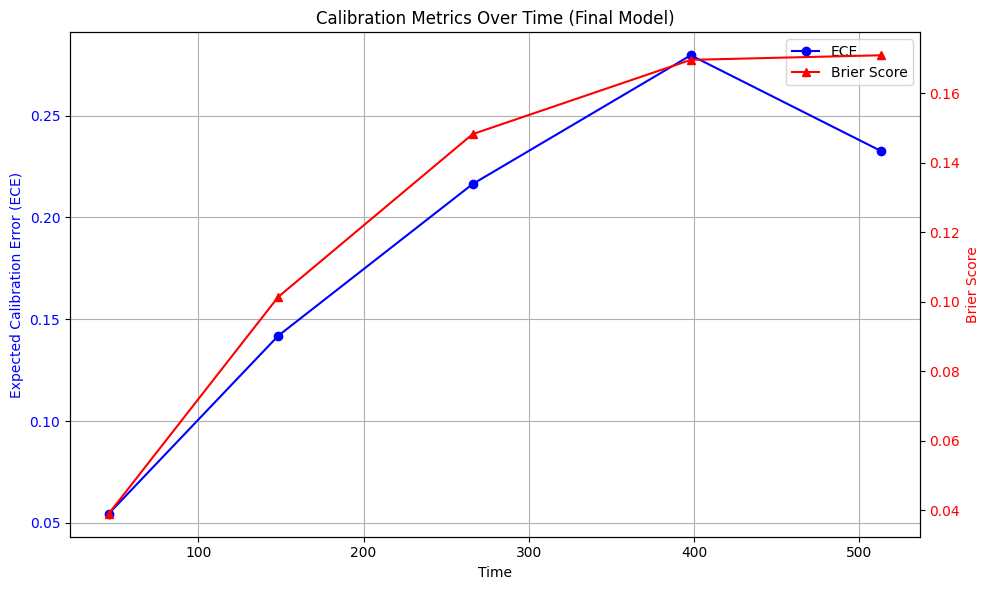

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from pyhealth.datasets import GBSGDataset
from pyhealth.tasks import SurvivalAnalysisGBSG
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc, integrated_brier_score, brier_score as sk_brier_score
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import optuna
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Fix seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Dataset Loading and Preprocessing ---
# Define dataset root directory
DATA_ROOT = "./datasets/"
# Create directory if it doesn't exist
os.makedirs(DATA_ROOT, exist_ok=True)

# Load dataset
# Load dataset
dataset = GBSGDataset(
    root="/content/datasets/",
    config_path="/content/PyHealth/pyhealth/datasets/configs/gbsg.yaml",
    dataset_name="gbsg_study"
)

# Create task
task = SurvivalAnalysisGBSG()
task_dataset = dataset.set_task(task)
print(f"Generated {len(task_dataset.samples)} samples for task {task.task_name}")



# Prepare features, times, events, and original_hormon for grouping
features_list, times_list, events_list, original_hormon_list = [], [], [], []

for sample in task_dataset.samples: # Iterating directly over samples maintains order
    # Extract features (all keys except patient_id, time, event)
    # Assuming 'hormon' is one of the features used by the model
    feat = {k: v for k, v in sample.items() if k not in ["patient_id", "time", "event"]}
    features_list.append(list(feat.values()))
    times_list.append(float(sample["time"]))
    events_list.append(int(sample["event"]))
    # Store the original 'hormon' value for later grouping
    original_hormon_list.append(int(sample["hormon"])) # Assume 'hormon' is 0 or 1 based on dataset info


# Convert lists to tensors
features = torch.tensor(features_list, dtype=torch.float32)
times = torch.tensor(times_list, dtype=torch.float32)
events = torch.tensor(events_list, dtype=torch.bool) # Use boolean for events

print(f"Loaded {features.shape[0]} samples with {features.shape[1]} features.")

# Normalize features
scaler = StandardScaler()
features_np = features.numpy() # Convert tensor to numpy for scikit-learn
features_scaled_np = scaler.fit_transform(features_np)
features = torch.tensor(features_scaled_np, dtype=torch.float32) # Convert back to tensor
print("Features normalized.")

# Identify indices for hormonal therapy groups based on original data
original_hormon_np = np.array(original_hormon_list)
hormon_1_indices = np.where(original_hormon_np == 1)[0].tolist()
hormon_0_indices = np.where(original_hormon_np == 0)[0].tolist()

print(f"Found {len(hormon_1_indices)} patients with hormonal therapy and {len(hormon_0_indices)} without.")


# Prepare stratification bins for K-Fold Cross-Validation
# Stratify by a combination of time bins and event status for more balanced folds
all_times_np = times.numpy()
all_events_np = events.numpy().astype(int)

# Create time bins using quantiles
try:
    time_bins = pd.qcut(all_times_np, q=5, labels=False, duplicates='drop')
    # Combine time bin index and event status (0 or 1) to create strata
    stratify_on = time_bins * 2 + all_events_np
    print("Stratifying by 5 time bins and event status.")
except ValueError:
    print("Could not create 5 unique time bins for stratification. Trying with 3 bins.")
    try:
        time_bins = pd.qcut(all_times_np, q=3, labels=False, duplicates='drop')
        stratify_on = time_bins * 2 + all_events_np
        print("Stratifying by 3 time bins and event status.")
    except ValueError:
        print("Could not create 3 unique time bins for stratification. Stratifying only by event status.")
        stratify_on = all_events_np # Fallback: stratify only by event status

# Create a TensorDataset from the prepared tensors
dataset_full = TensorDataset(features, times, events)

# --- Survival Model Definition (Static MLP) ---
class StaticHazardModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim), # BatchNorm after linear layer
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2), # Intermediate layer
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1) # Output a single risk score
        )

    def forward(self, x):
        # Ensure input has at least 2 dimensions for BatchNorm1d
        if x.dim() == 1:
            x = x.unsqueeze(0)
        hazard = self.net(x).squeeze() # Squeeze to remove the last dimension if it's 1
        # Handle batch size 1 case where squeeze might remove the batch dim
        if hazard.dim() == 0:
             hazard = hazard.unsqueeze(0)
        return hazard

# --- Cox Loss Function (Corrected) ---
def cox_loss(hazards, times, events):
    # Ensure inputs are on the same device
    hazards = hazards.to(device)
    times = times.to(device)
    events = events.to(device)

    # Sort by time in descending order
    order = torch.argsort(times, descending=True)
    hazards = hazards[order]
    events = events[order]

    # Calculate log-risk for each patient
    # Risk set includes all patients with time >= current patient's time
    # Use cumsum on exp(hazards) after sorting by time
    hazards_exp = torch.exp(hazards)
    # Add a small epsilon to the cumsum for numerical stability, especially if sum is zero
    log_risk = torch.log(torch.cumsum(hazards_exp, dim=0) + 1e-8)

    # Calculate partial likelihood term for each patient
    # partial_likelihood = risk_score * event_indicator - log(sum_of_risk_scores_in_risk_set)
    partial_likelihood = hazards * events - log_risk

    # Sum partial likelihood only for uncensored events (events == True)
    mask = events.bool() # Ensure mask is boolean type
    partial_likelihood_observed = partial_likelihood[mask]

    # Average the negative partial likelihood over the number of observed events
    num_observed_events = mask.sum()
    if num_observed_events == 0:
        # If no events in the batch, return a zero tensor.
        # Crucially, set requires_grad based on whether the input hazards required grad.
        # This ensures the loss tensor is part of the graph if needed for backprop.
        loss = torch.tensor(0.0, device=device, requires_grad=hazards.requires_grad)
    else:
        loss = -partial_likelihood_observed.sum() / num_observed_events

    return loss

# --- Calibration Metrics Calculation (Corrected Brier Score using sksurv) ---
def calculate_calibration_metrics(model, dataloader, device, eval_times, y_train, q=10):
    """
    Calculates time-dependent calibration metrics (ECE, Brier) and survival probabilities.

    Args:
        model: The trained PyTorch model.
        dataloader: DataLoader for the evaluation dataset.
        device: The device to use ('cuda' or 'cpu').
        eval_times (list or np.array): List of time points at which to evaluate metrics.
        y_train (Surv): Survival data (event indicator and time) for the training set.
                       Used by sksurv metrics to estimate the censoring distribution.
        q (int): Number of quantiles for ECE calculation.

    Returns:
        dict: A dictionary containing:
            "ECE_at_times" (list): List of ECE scores at each eval_time.
            "Brier_at_times" (list): List of Brier scores at each eval_time.
            "EvalTimes" (list): The evaluation time points used.
            "survival_probs" (np.array): Predicted survival probabilities (n_samples, n_times).
                                         Returns None if calculation fails.
    """
    model.eval() # Set model to evaluation mode
    all_hazards, all_times, all_events = [], [], []

    # Collect hazards, times, and events from the dataloader
    with torch.no_grad():
        for X_batch, t_batch, e_batch in dataloader:
            X_batch = X_batch.to(device)
            hazards = model(X_batch).cpu().numpy().flatten() # Get hazards and move to CPU
            all_hazards.extend(hazards)
            all_times.extend(t_batch.numpy())
            all_events.extend(e_batch.numpy())

    all_hazards = np.array(all_hazards)
    all_events = np.array(all_events, dtype=bool)
    all_times = np.array(all_times)

    # Create sksurv Surv object for the evaluation dataset
    y_true = Surv.from_arrays(event=all_events, time=all_times)

    ece_scores = []
    brier_scores = []
    survival_probs = None # Default to None

    try:
        # --- Calculate Predicted Survival Probabilities at eval_times using Breslow Estimator ---
        # This requires calculating the baseline cumulative hazard.
        # Sort data by time to calculate risk sets and baseline hazard
        order = np.argsort(all_times)
        sorted_hazards = all_hazards[order]
        sorted_times = all_times[order]
        sorted_events = all_events[order]

        # Calculate baseline cumulative hazard based on observed events in the evaluation data
        # This is needed to predict survival probabilities for the evaluation set itself.
        unique_observed_times_eval = np.unique(sorted_times[sorted_events])
        baseline_hazard_increments_eval = {}

        for t in unique_observed_times_eval:
            # Indices of patients at risk at time t (time >= t) in the *evaluation* set
            risk_set_indices_at_t = np.where(sorted_times >= t)[0]
            if len(risk_set_indices_at_t) > 0:
                risk_set_sum_at_t = np.sum(np.exp(sorted_hazards[risk_set_indices_at_t]))
                if risk_set_sum_at_t > 0:
                     # Number of observed events occurring exactly at time t in the evaluation set
                     num_observed_events_at_t = np.sum(sorted_events[sorted_times == t])
                     if num_observed_events_at_t > 0:
                         baseline_hazard_increments_eval[t] = num_observed_events_at_t / risk_set_sum_at_t
                     else:
                         baseline_hazard_increments_eval[t] = 0
            else:
                 baseline_hazard_increments_eval[t] = 0

        # Build the cumulative baseline hazard function from the evaluation data
        cumulative_baseline_hazard_func_eval = {}
        cumulative_sum = 0
        sorted_unique_observed_times_eval = sorted(baseline_hazard_increments_eval.keys())
        for t in sorted_unique_observed_times_eval:
            cumulative_sum += baseline_hazard_increments_eval[t]
            cumulative_baseline_hazard_func_eval[t] = cumulative_sum

        # Calculate survival probabilities S(t|x) = exp(-H_0_eval(t) * exp(h(x))) at eval_times
        # using the baseline cumulative hazard estimated from the *evaluation* data.
        survival_probs = np.zeros((len(all_hazards), len(eval_times)))
        for i, t in enumerate(eval_times):
            # Find the cumulative baseline hazard up to time t from the evaluation set estimates
            relevant_times = [ut for ut in sorted_unique_observed_times_eval if ut <= t]
            if relevant_times:
                cum_hazard_at_t = cumulative_baseline_hazard_func_eval[relevant_times[-1]]
                # Survival probability for each individual at time t
                survival_probs[:, i] = np.clip(np.exp(-cum_hazard_at_t * np.exp(all_hazards)), 1e-8, 1 - 1e-8)
            else:
                 # For times before the first observed event in the evaluation set, survival is 1
                 survival_probs[:, i] = 1.0

        # Ensure survival curves are non-increasing over time
        for i in range(1, survival_probs.shape[1]):
            survival_probs[:, i] = np.minimum(survival_probs[:, i], survival_probs[:, i - 1])


        # --- Calculate Expected Calibration Error (ECE) at each eval_time ---
        # For simplicity here, using the basic average within bins without explicit IPCW.
        for i, t in enumerate(eval_times):
            # True survival status at time t (1 if survived beyond t, 0 otherwise) in the evaluation set
            y_event_gt_t = (all_times > t).astype(float)
            # Predicted survival probability at time t
            y_pred = survival_probs[:, i]

            # Bin predictions into quantiles
            sorted_indices = np.argsort(y_pred)
            bin_indices = np.array_split(sorted_indices, q)

            ece = 0.0
            total_samples = len(y_pred)

            for indices in bin_indices:
                if len(indices) == 0:
                    continue # Skip empty bins
                bin_pred = y_pred[indices]
                bin_event_gt_t = y_event_gt_t[indices]

                # Average predicted probability and true event status within the bin
                avg_pred = np.mean(bin_pred)
                avg_event = np.mean(bin_event_gt_t)

                # Weighted difference, weighted by the proportion of samples in the bin
                ece += abs(avg_event - avg_pred) * len(indices) / total_samples

            ece_scores.append(ece)

        # --- Calculate Brier Score at each eval_time using sksurv ---
        # sksurv.metrics.brier_score handles IPCW internally based on y_train.
        try:
            # sk_brier_score requires:
            # - y_train: survival data for the training set (used for censoring estimate)
            # - y_true: survival data for the test/validation set
            # - survival_probs: predicted survival probabilities for the test/validation set (n_samples, n_times)
            # - times: the time points at which to evaluate the Brier score
            time_points_bs, bs_at_times = sk_brier_score(y_train, y_true, survival_probs, times=eval_times)

            # Ensure the returned times match the requested times, and scores match.
            # sk_brier_score returns scores corresponding to the input 'times'.
            brier_scores = bs_at_times.tolist() # Convert numpy array to list

        except Exception as e:
            print(f"Error computing Brier scores using sksurv: {str(e)}")
            # If sk_brier_score fails, return a list of NaNs matching the number of eval_times
            brier_scores = [float('nan')] * len(eval_times)

    except Exception as e:
         print(f"Error during survival probability or calibration metrics calculation: {str(e)}")
         # If any step in this try block fails, set scores to NaN and survival_probs to None
         ece_scores = [float('nan')] * len(eval_times)
         brier_scores = [float('nan')] * len(eval_times)
         survival_probs = None


    return {
        "ECE_at_times": ece_scores,
        "Brier_at_times": brier_scores,
        "EvalTimes": eval_times,
        "survival_probs": survival_probs # Return survival probabilities for IBS calculation
    }

# --- Evaluation Metrics Function ---
def evaluate_model(model, dataloader, device, eval_times, y_train):
    """
    Evaluates the survival model using various metrics.

    Args:
        model: The trained PyTorch model.
        dataloader: DataLoader for the evaluation dataset.
        device: The device to use ('cuda' or 'cpu').
        eval_times (list or np.array): List of time points at which to evaluate time-dependent metrics.
        y_train (Surv): Survival data (event indicator and time) for the training set.
                       Used by sksurv metrics (AUC, IBS, Brier) for censoring adjustment.

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    model.eval() # Set model to evaluation mode
    all_hazards, all_times, all_events = [], [], []

    # Collect hazards, times, and events from the dataloader
    with torch.no_grad():
        for X_batch, t_batch, e_batch in dataloader:
            X_batch = X_batch.to(device)
            hazards = model(X_batch).cpu().numpy().flatten() # Get hazards and move to CPU
            all_hazards.extend(hazards)
            all_times.extend(t_batch.numpy())
            all_events.extend(e_batch.numpy())

    all_hazards = np.array(all_hazards)
    all_events = np.array(all_events, dtype=bool)
    all_times = np.array(all_times)

    # Create sksurv Surv object for the evaluation dataset (y_true)
    y_true = Surv.from_arrays(event=all_events, time=all_times)

    # --- Concordance Index (Ctd) ---
    # Ctd is calculated on predicted risk scores (hazards) and observed data
    # Higher hazard for earlier events means higher Ctd.
    ctd = float('nan') # Default to NaN
    try:
        if len(all_events) > 1: # Need at least 2 samples for Ctd
            ctd = concordance_index_censored(all_events, all_times, all_hazards)[0]
        else:
             print("Warning: Less than 2 samples for Ctd calculation.")
    except Exception as e:
        print(f"Error computing Ctd: {str(e)}")


    # --- Time-dependent AUC ---
    # Calculated on predicted risk scores (hazards) at specific time points.
    # Requires censoring adjustment based on the training data (y_train).
    auc_scores_list = []
    valid_times_auc_list = []
    avg_auc = float('nan') # Default to NaN

    try:
        # sksurv's cumulative_dynamic_auc requires:
        # - y_train: survival data for the training set (used for censoring estimate)
        # - y_true: survival data for the test/validation set
        # - estimate: predicted risk scores (all_hazards)
        # - times: the time points at which to evaluate the AUC
        # It returns two numpy arrays: (times, auc_scores) for the valid times.
        # It handles cases where AUC cannot be computed (e.g., censoring issues) by not returning those times/scores.
        # Ensure eval_times is not empty and there is enough data for sksurv metrics
        if eval_times and len(y_true) > 1 and len(y_train) > 1:
            computed_times_auc, computed_auc_scores = cumulative_dynamic_auc(y_train, y_true, all_hazards, eval_times)

            # Ensure the results are numpy arrays and filter out NaNs just in case
            computed_times_auc = np.asarray(computed_times_auc)
            computed_auc_scores = np.asarray(computed_auc_scores)

            # Filter out NaN AUC scores if any
            valid_mask_auc = ~np.isnan(computed_auc_scores)
            valid_times_auc_np = computed_times_auc[valid_mask_auc]
            auc_scores_np = computed_auc_scores[valid_mask_auc]

            # Convert to list for return dictionary
            valid_times_auc_list = valid_times_auc_np.tolist()
            auc_scores_list = auc_scores_np.tolist()

            # Calculate the average AUC over the valid times
            avg_auc = np.mean(auc_scores_np) if len(auc_scores_np) > 0 else float('nan')
        else:
            print("Warning: Insufficient data or empty eval_times for Time-dependent AUC calculation.")


    except Exception as e:
        print(f"Error computing Time-dependent AUC: {str(e)}")
        # avg_auc is already nan
        # Keep lists empty


    # --- Calibration Metrics (ECE and Time-dependent Brier) ---
    # Calculated using the helper function, which uses sk_brier_score internally.
    # This function also returns the survival probabilities needed for IBS.
    calibration_metrics = calculate_calibration_metrics(model, dataloader, device, eval_times, y_train)

    # --- Integrated Brier Score (IBS) ---
    # Calculated over the range of evaluation times using predicted survival curves.
    # Requires censoring adjustment based on the training data (y_train).
    ibs = float('nan') # Default to NaN
    try:
        # Check if survival_probs were successfully generated and eval_times is not empty
        if calibration_metrics["survival_probs"] is not None and \
           calibration_metrics["survival_probs"].shape[1] == len(eval_times) and \
           len(eval_times) > 0 and len(y_true) > 1 and len(y_train) > 1: # Need enough data for IBS
             # sksurv's integrated_brier_score requires:
             # - y_train: survival data for the training set (used for censoring estimate)
             # - y_true: survival data for the test/validation set
             # - survival_probs: predicted survival probabilities over time (n_samples, n_times)
             # - times: the time points corresponding to survival_probs
             ibs = integrated_brier_score(y_train, y_true, calibration_metrics["survival_probs"], eval_times)
        else:
             print("Warning: Survival probabilities or eval_times not available/valid for IBS calculation.")

    except Exception as e:
        print(f"Error computing IBS: {str(e)}")


    return {
        "Ctd": ctd,
        "AUC": avg_auc, # Average AUC over valid times
        "AUC_at_times": (valid_times_auc_list, auc_scores_list), # AUC scores at specific times (as lists)
        "IBS": ibs,
        "ECE_at_times": calibration_metrics["ECE_at_times"], # List of ECE scores per time
        "Brier_at_times": calibration_metrics["Brier_at_times"], # List of Brier scores per time
        "eval_times": eval_times, # List of evaluation times used
        "survival_probs": calibration_metrics["survival_probs"] # Include survival probs for plotting
    }

# --- Optuna Objective Function ---
def objective(trial):
    """
    Objective function for Optuna hyperparameter tuning. Performs K-Fold CV
    and returns the average Integrated Brier Score (IBS) across folds.
    """
    # Define hyperparameter search space
    params = {
        "lr": trial.suggest_float("lr", 1e-4, 5e-3, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128]),
        "hidden_dim": trial.suggest_int("hidden_dim", 64, 256), # Reduced range slightly for faster tuning
        "dropout": trial.suggest_float("dropout", 0.2, 0.5),
        "weight_decay": trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True),
        "epochs": 50, # Maximum epochs per fold, early stopping will be used
        "n_splits": 5 # Number of folds for cross-validation
    }

    print(f"\nTrial {trial.number} with parameters: {params}")

    # Setup Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=params["n_splits"], shuffle=True, random_state=SEED)

    # Lists to store metrics from each fold
    fold_ctd = []
    fold_auc = []
    fold_ibs = []
    fold_ece_at_times = [] # Store lists of ECE scores per time per fold
    fold_brier_at_times = [] # Store lists of Brier scores per time per fold
    fold_eval_times_list = [] # Store the evaluation times used for each fold

    # Use the pre-calculated stratification bins (`stratify_on`)
    # skf.split returns indices, so we pass `features` (or any array-like of the correct size)
    # and the `stratify_on` array.
    split_generator = skf.split(features, stratify_on)

    for fold_idx, (train_idx, val_idx) in enumerate(split_generator):
        print(f"--- Fold {fold_idx + 1}/{params['n_splits']} ---")

        # Need y_train for sksurv metrics (censoring estimation)
        # y_train should represent the data the model was trained on in this fold
        train_subset = Subset(dataset_full, train_idx)
        # DataLoader to easily iterate and collect times/events
        train_data_for_y_train = DataLoader(train_subset, batch_size=len(train_subset)) # Load all at once
        t_train_np, e_train_np = [], []
        with torch.no_grad():
            for _, t_batch, e_batch in train_data_for_y_train:
                 t_train_np.extend(t_batch.numpy())
                 e_train_np.extend(e_batch.numpy())
        y_train = Surv.from_arrays(event=np.array(e_train_np, dtype=bool), time=np.array(t_train_np))

        # Determine evaluation times for this fold based on percentiles of event times in the training split
        train_times_fold = times[train_idx].numpy()
        train_events_fold = events[train_idx].numpy()
        event_times_train_fold = train_times_fold[train_events_fold]

        # Handle cases with no events in the training fold
        if len(event_times_train_fold) == 0:
             print(f"Warning: No events in train fold {fold_idx + 1}. Using all training times for initial eval_times percentiles.")
             event_times_train_fold = train_times_fold
             # If there are no times at all in the train fold (empty split?), skip
             if len(event_times_train_fold) == 0:
                 print(f"Error: No data in train fold {fold_idx + 1}. Skipping evaluation for this fold.")
                 fold_ctd.append(float('nan'))
                 fold_auc.append(float('nan'))
                 fold_ibs.append(float('nan'))
                 fold_ece_at_times.append([])
                 fold_brier_at_times.append([])
                 fold_eval_times_list.append([])
                 continue

        try:
            # Calculate initial evaluation times as percentiles
            initial_eval_times = np.percentile(event_times_train_fold, [10, 30, 50, 70, 90]).tolist()
            initial_eval_times = sorted(list(set(initial_eval_times))) # Ensure unique and sorted

        except Exception as e:
            print(f"Error determining initial eval_times for fold {fold_idx + 1}: {str(e)}. Skipping evaluation for this fold.")
            fold_ctd.append(float('nan'))
            fold_auc.append(float('nan'))
            fold_ibs.append(float('nan'))
            fold_ece_at_times.append([])
            fold_brier_at_times.append([])
            fold_eval_times_list.append([])
            continue

        # --- Filter eval_times to be strictly less than the maximum training time ---
        # This is crucial for sksurv metrics that rely on censoring estimation from y_train.
        # Get the maximum time from the actual y_train data used in this fold
        max_train_time = y_train['time'].max()
        # Only keep evaluation times that are strictly less than the max training time
        valid_eval_times = [t for t in initial_eval_times if t < max_train_time]

        # Check if there are still valid eval times after filtering
        if not valid_eval_times:
            print(f"Warning: All determined initial eval_times for fold {fold_idx + 1} are >= max training time ({max_train_time}). Skipping evaluation for this fold.")
            # Append NaN/empty lists as before
            fold_ctd.append(float('nan'))
            fold_auc.append(float('nan'))
            fold_ibs.append(float('nan'))
            fold_ece_at_times.append([])
            fold_brier_at_times.append([])
            fold_eval_times_list.append([])
            continue # Skip evaluation for this fold

        # Use the filtered times for evaluation in this fold
        eval_times = valid_eval_times
        fold_eval_times_list.append(eval_times) # Store the *actual* times used for this fold


        # Create DataLoaders for training and validation splits
        train_loader = DataLoader(Subset(dataset_full, train_idx), batch_size=params["batch_size"], shuffle=True)
        val_loader = DataLoader(Subset(dataset_full, val_idx), batch_size=params["batch_size"])

        # Initialize model, optimizer, and scheduler for the current fold
        model = StaticHazardModel(
            input_dim=features.shape[1],
            hidden_dim=params["hidden_dim"],
            dropout=params["dropout"]
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
        # ReduceLROnPlateau reduces LR when a metric (validation loss) has stopped improving
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=False) # Increased patience

        # --- Training Loop for the current fold ---
        best_val_loss = float('inf')
        no_improvement = 0
        max_no_improvement = 10 # Early stopping patience

        print(f"Starting training for fold {fold_idx + 1}...")
        for epoch in range(params["epochs"]):
            model.train() # Set model to training mode
            total_train_loss = 0
            num_batches = 0
            for X_batch, t_batch, e_batch in train_loader:
                X_batch, t_batch, e_batch = X_batch.to(device), t_batch.to(device), e_batch.to(device)
                risks = model(X_batch)
                loss = cox_loss(risks, t_batch, e_batch)

                # Only perform backprop if loss is a valid number (not NaN or Inf)
                # The loss function now handles the requires_grad for the 0-event case.
                if not torch.isnan(loss) and not torch.isinf(loss):
                    optimizer.zero_grad() # Zero gradients
                    loss.backward() # Backpropagation
                    # Gradient clipping to prevent exploding gradients
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step() # Update weights
                    total_train_loss += loss.item()
                    num_batches += 1
                else:
                    print(f"Warning: Training loss is NaN/Inf at epoch {epoch + 1}, batch {num_batches}. Skipping update.")


            # --- Validation Step ---
            model.eval() # Set model to evaluation mode
            val_losses = []
            with torch.no_grad(): # No gradient calculation in evaluation
                for X_batch, t_batch, e_batch in val_loader:
                    X_batch, t_batch, e_batch = X_batch.to(device), t_batch.to(device), e_batch.to(device)
                    risks = model(X_batch)
                    v_loss = cox_loss(risks, t_batch, e_batch).item()
                    # Only consider valid loss values
                    if not np.isnan(v_loss) and not np.isinf(v_loss):
                         val_losses.append(v_loss)

            avg_val_loss = np.mean(val_losses) if val_losses else float('inf') # Handle case with no valid val losses

            # Step the learning rate scheduler based on validation loss
            scheduler.step(avg_val_loss)

            # Early stopping check based on validation loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improvement = 0
                # Optionally save best model state dict here if you want to restore the best epoch model
                # torch.save(model.state_dict(), f"best_model_fold_{fold_idx}_trial_{trial.number}.pt")
            else:
                no_improvement += 1

            # print(f"Fold {fold_idx + 1}, Epoch {epoch + 1}, Train Loss: {total_train_loss/(num_batches+1e-8):.4f}, Val Loss: {avg_val_loss:.4f}, No Improvement: {no_improvement}")

            if no_improvement >= max_no_improvement:
                print(f"Early stopping at epoch {epoch + 1} for fold {fold_idx + 1}")
                # Optionally load the best model state if saved
                # try:
                #      model.load_state_dict(torch.load(f"best_model_fold_{fold_idx}_trial_{trial.number}.pt"))
                #      print("Loaded best model state for evaluation.")
                # except FileNotFoundError:
                #      print("Best model state not found, using last epoch model.")
                break # Exit epoch loop for this fold

        # --- Evaluate the trained model on the validation split for this fold ---
        # Evaluate the model on the validation loader using the *filtered* eval_times for this fold
        # y_train for sksurv metrics needs to be from the training data of this fold
        fold_results = evaluate_model(model, val_loader, device, eval_times, y_train)

        # Append the metrics from this fold to the lists
        fold_ctd.append(fold_results["Ctd"])
        fold_auc.append(fold_results["AUC"])
        fold_ibs.append(fold_results["IBS"])
        fold_ece_at_times.append(fold_results["ECE_at_times"])
        fold_brier_at_times.append(fold_results["Brier_at_times"])

    # --- Aggregate Metrics Across Folds ---
    # Average the single-value metrics (Ctd, AUC, IBS)
    avg_ctd = np.nanmean(fold_ctd) if fold_ctd else float('nan')
    avg_auc = np.nanmean(fold_auc) if fold_auc else float('nan')
    avg_ibs = np.nanmean(fold_ibs) if fold_ibs else float('nan')

    # Aggregate time-dependent metrics (ECE, Brier)
    # We need to average the scores at corresponding time points across folds.
    # Since eval_times might differ slightly per fold (due to percentiles on different splits),
    # we average the *average* time-dependent score within each fold, then average these averages.

    avg_ece_per_fold = [np.nanmean(ece_list) if ece_list else float('nan') for ece_list in fold_ece_at_times]
    avg_brier_per_fold = [np.nanmean(brier_list) if brier_list else float('nan') for brier_list in fold_brier_at_times]

    overall_avg_ece_at_times = np.nanmean(avg_ece_per_fold) if avg_ece_per_fold else float('nan')
    overall_avg_brier_at_times = np.nanmean(avg_brier_per_fold) if avg_brier_per_fold else float('nan')


    # Report aggregated metrics
    trial_results = {
        "Ctd": avg_ctd,
        "AUC": avg_auc,
        "IBS": avg_ibs,
        "Avg_ECE_over_times": overall_avg_ece_at_times,
        "Avg_Brier_over_times": overall_avg_brier_at_times,
        # Could also include the averaged curves if plotting within Optuna dashboard is set up
    }

    print(f"Trial {trial.number} Results (averaged over folds): {trial_results}")

    # Optuna minimizes the objective. Use IBS as the primary objective metric.
    # Return a high value if IBS is NaN (e.g., no events in any validation fold).
    return avg_ibs if not np.isnan(avg_ibs) else float('inf')

# --- Run Optuna Study ---
print("\nStarting Optuna study...")
# Create a study object. Specify the direction is 'minimize' for IBS.
study = optuna.create_study(direction="minimize")

# Optimize the study. n_trials is the number of parameter sets to try.
# timeout is the maximum time in seconds for the study.
study.optimize(objective, n_trials=50, timeout=7200) # Run up to 50 trials or 2 hours

print("\nOptuna study finished.")
print("Best trial:")
print(f"  Value (IBS): {study.best_trial.value:.4f}")
print(f"  Params: {study.best_trial.params}")

# --- Retrain Best Model on the Full Dataset ---
print("\nRetraining the best model on the full dataset...")
best_params = study.best_trial.params

# Initialize the model with the best hyperparameters found by Optuna
best_model = StaticHazardModel(
    input_dim=features.shape[1],
    hidden_dim=best_params["hidden_dim"],
    dropout=best_params["dropout"]
).to(device)

# Create a DataLoader for the full dataset for retraining
full_train_loader = DataLoader(dataset_full, batch_size=best_params["batch_size"], shuffle=True)

# Initialize optimizer for the final training
optimizer = optim.Adam(best_model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])

# Optional: Use a learning rate scheduler for the final training as well
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=False)

# Train the best model on the full dataset for a fixed number of epochs
# Or implement early stopping based on a held-out validation set if available,
# or based on training loss plateau. Training on the full data for a fixed number
# of epochs (or until loss stabilizes) is a common practice after CV tuning.
print("Training the final model...")
# Choose a reasonable number of epochs. Could be more than in CV folds.
FINAL_TRAIN_EPOCHS = 100

for epoch in range(FINAL_TRAIN_EPOCHS):
    best_model.train() # Set model to training mode
    total_loss = 0
    num_batches = 0
    for X_batch, t_batch, e_batch in full_train_loader:
        X_batch, t_batch, e_batch = X_batch.to(device), t_batch.to(device), e_batch.to(device)
        risks = best_model(X_batch)
        loss = cox_loss(risks, t_batch, e_batch)

        # Only perform backprop if loss is a valid number (not NaN or Inf)
        # The loss function now handles the requires_grad for the 0-event case.
        if not torch.isnan(loss) and not torch.isinf(loss):
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(best_model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        else:
             print(f"Warning: Final training loss is NaN/Inf at epoch {epoch + 1}, batch {num_batches}. Skipping update.")

    avg_train_loss = total_loss / (num_batches + 1e-8)
    # Optional: Step scheduler based on training loss for full dataset training
    # scheduler.step(avg_train_loss)

    # Optional: Print loss during full training
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Final Model Training - Epoch {epoch + 1}/{FINAL_TRAIN_EPOCHS}, Loss: {avg_train_loss:.4f}")

    # Optional: Simple convergence check based on training loss (less rigorous than val loss)
    # if avg_train_loss < 0.1 and epoch > 10: # Example threshold
    #     print(f"Final model training converged at epoch {epoch + 1}")
    #     break


print("Final model training complete.")

# --- Final Evaluation on the Full Dataset ---
print("\nPerforming final evaluation on the full dataset...")

# Need the survival data (times and events) for the full dataset to create y_true_full
all_times_full, all_events_full = [], []
# Use a DataLoader to iterate through the full dataset
full_dataset_loader_eval = DataLoader(dataset_full, batch_size=len(dataset_full)) # Load all at once

with torch.no_grad():
    for _, t_batch, e_batch in full_dataset_loader_eval:
        all_times_full.extend(t_batch.numpy())
        all_events_full.extend(e_batch.numpy())

# Create the sksurv Surv object for the full dataset (this is both y_train and y_true for final eval)
y_full_data_sksurv = Surv.from_arrays(event=np.array(all_events_full, dtype=bool), time=np.array(all_times_full))

# Determine initial evaluation times for the final plot based on event times in the full dataset
event_times_full = np.array(all_times_full)[np.array(all_events_full, dtype=bool)]
if len(event_times_full) > 0:
    # Use percentiles of observed event times on the full dataset
    initial_eval_times_final = np.percentile(event_times_full, [10, 30, 50, 70, 90]).tolist()
    initial_eval_times_final = sorted(list(set(initial_eval_times_final))) # Ensure unique and sorted
    if not initial_eval_times_final:
        print("Warning: Could not determine meaningful initial final eval_times from event times. Using percentiles of all times.")
        initial_eval_times_final = np.percentile(np.array(all_times_full), [10, 30, 50, 70, 90]).tolist()
        initial_eval_times_final = sorted(list(set(initial_eval_times_final)))
else:
    print("Warning: No events in the full dataset. Using percentiles of all times for initial final eval_times.")
    initial_eval_times_final = np.percentile(np.array(all_times_full), [10, 30, 50, 70, 90]).tolist()
    initial_eval_times_final = sorted(list(set(initial_eval_times_final)))

# --- Filter final eval_times to be strictly less than the maximum time in the full dataset ---
# This is crucial for sksurv metrics when y_train and y_true are the full dataset.
max_full_data_time = y_full_data_sksurv['time'].max()
valid_eval_times_final = [t for t in initial_eval_times_final if t < max_full_data_time]

# Check if there are valid times after filtering
if not valid_eval_times_final:
     print(f"Error: All final initial eval_times are >= max full dataset time ({max_full_data_time}). Cannot perform final evaluation with time-dependent metrics.")
     # Handle gracefully, maybe print some basic metrics that don't need eval_times (like Ctd)
     final_metrics = {"Ctd": float('nan'), "AUC": float('nan'), "AUC_at_times": ([], []), "IBS": float('nan'), "ECE_at_times": [], "Brier_at_times": [], "eval_times": [], "survival_probs": None}
     print("Final Metrics (evaluated on the full dataset):")
     print(f"  Concordance Index (Ctd): {final_metrics['Ctd']:.4f}")
     print(f"  Time-dependent AUC (avg over times): {final_metrics['AUC']:.4f}")
     print(f"  Integrated Brier Score (IBS): {final_metrics['IBS']:.4f}")
     print(f"  Expected Calibration Error (ECE, avg over times): {np.nanmean(final_metrics['ECE_at_times']):.4f}")
     print(f"  Brier Score (avg over times): {np.nanmean(final_metrics['Brier_at_times']):.4f}")

     # Skip plotting if no valid eval times
     plot_calibration_possible = False
     plot_auc_possible = False
     plot_survival_curve_possible = False
     plot_group_comparison_possible = False # Also add flag for the new plot

else:
    # Use the filtered times for final evaluation
    eval_times_final = valid_eval_times_final
    # Perform final evaluation on the full dataset using the best model
    # For sksurv metrics in this final step, y_train and y_true are the same (the full dataset)
    final_metrics = evaluate_model(best_model, DataLoader(dataset_full, batch_size=128), device, eval_times_final, y_full_data_sksurv) # Use a reasonable batch size for evaluation

    # Print Final Metrics
    print("\nFinal Evaluation Metrics (on the full dataset):")
    print(f"  Concordance Index (Ctd): {final_metrics['Ctd']:.4f}")
    print(f"  Time-dependent AUC (avg over times): {final_metrics['AUC']:.4f}")
    print(f"  Integrated Brier Score (IBS): {final_metrics['IBS']:.4f}")
    # Report average ECE and Brier over the evaluation times
    print(f"  Expected Calibration Error (ECE, avg over times): {np.nanmean(final_metrics['ECE_at_times']):.4f}")
    print(f"  Brier Score (avg over times): {np.nanmean(final_metrics['Brier_at_times']):.4f}")

    # Check if plotting is possible
    valid_brier_mask = ~np.isnan(final_metrics["Brier_at_times"])
    valid_ece_mask = ~np.isnan(final_metrics["ECE_at_times"])
    valid_mask = valid_brier_mask & valid_ece_mask
    plot_calibration_possible = np.any(valid_mask)
    plot_auc_possible = final_metrics["AUC_at_times"] and len(final_metrics["AUC_at_times"][0]) > 0
    plot_survival_curve_possible = final_metrics["survival_probs"] is not None and final_metrics["eval_times"] is not None and len(final_metrics["eval_times"]) > 0
    # Check if group comparison plot is possible (requires survival probs and group indices)
    plot_group_comparison_possible = plot_survival_curve_possible and hormon_1_indices and hormon_0_indices


# --- Plot Calibration Metrics Over Time ---
def plot_calibration(ece_scores_at_times, brier_scores_at_times, eval_times):
    """Plots time-dependent ECE and Brier scores."""
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot ECE
    ax1.plot(eval_times, ece_scores_at_times, 'b', marker="o", linestyle='-', label="ECE")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Expected Calibration Error (ECE)", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)

    # Create a second y-axis for Brier Score
    ax2 = ax1.twinx()
    ax2.plot(eval_times, brier_scores_at_times, 'r', marker="^", linestyle='-', label="Brier Score")
    ax2.set_ylabel("Brier Score", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title("Calibration Metrics Over Time (Final Model)")
    fig.tight_layout() # Adjust layout to prevent labels overlapping

    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.show()

# Plot calibration if possible
if plot_calibration_possible:
    # Use the valid times and scores determined earlier
    valid_brier_mask = ~np.isnan(final_metrics["Brier_at_times"])
    valid_ece_mask = ~np.isnan(final_metrics["ECE_at_times"])
    valid_mask = valid_brier_mask & valid_ece_mask
    plot_calibration(
        np.array(final_metrics["ECE_at_times"])[valid_mask],
        np.array(final_metrics["Brier_at_times"])[valid_mask],
        np.array(final_metrics["eval_times"])[valid_mask]
    )
else:
    print("\nCould not plot calibration metrics as either ECE or Brier scores are all NaN for the valid mask.")
    # Fallback plotting if at least one of them is valid individually
    if np.any(~np.isnan(final_metrics["Brier_at_times"])) or np.any(~np.isnan(final_metrics["ECE_at_times"])):
        print("Attempting partial calibration plot...")
        valid_brier_mask = ~np.isnan(final_metrics["Brier_at_times"])
        valid_ece_mask = ~np.isnan(final_metrics["ECE_at_times"])
        if np.any(valid_brier_mask):
             plt.figure(figsize=(10, 6))
             plt.plot(np.array(final_metrics["eval_times"])[valid_brier_mask], np.array(final_metrics["Brier_at_times"])[valid_brier_mask], 'r', marker="^", linestyle='-', label="Brier Score")
             plt.xlabel("Time")
             plt.ylabel("Brier Score")
             plt.title("Brier Score Over Time (Final Model)")
             plt.legend()
             plt.grid(True)
             plt.show()
        if np.any(valid_ece_mask):
             plt.figure(figsize=(10, 6))
             plt.plot(np.array(final_metrics["eval_times"])[valid_ece_mask], np.array(final_metrics["ECE_at_times"])[valid_ece_mask], 'b', marker="o", linestyle='-', label="ECE")
             plt.xlabel("Time")
             plt.ylabel("Expected Calibration Error (ECE)")
             plt.title("Expected Calibration Error Over Time (Final Model)")
             plt.legend()
             plt.grid(True)
             plt.show()


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader # Assuming you have this
# Assuming lifelines is installed and imported
try:
    from lifelines import KaplanMeierFitter
    from lifelines.statistics import logrank_test
    lifelines_available = True
except ImportError:
    print("Warning: lifelines library not found. Kaplan-Meier plotting and log-rank test will be skipped.")
    lifelines_available = False
# Assuming sksurv is installed and imported for kaplan_meier_estimator if used elsewhere
try:
    from sksurv.nonparametric import kaplan_meier_estimator
    sksurv_available = True
except ImportError:
    print("Warning: scikit-survival library not found. Some functionality might be affected if used elsewhere.")
    sksurv_available = False

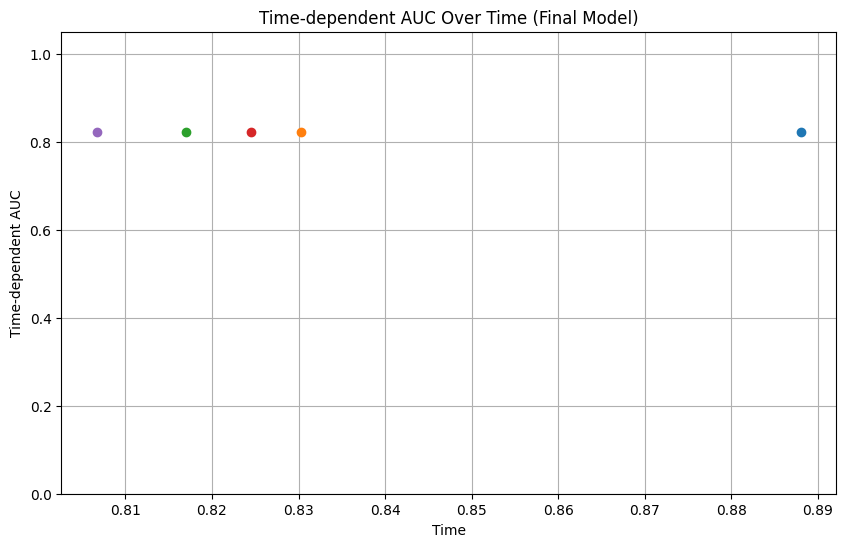


Plotting predicted survival curves vs Kaplan-Meier for sample individuals...


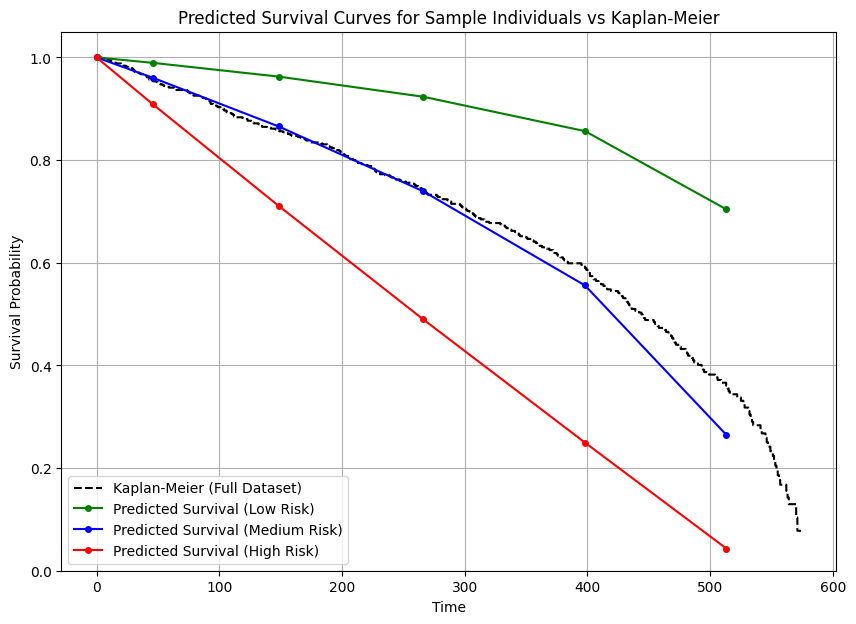


Comparing model predicted group survival vs Kaplan-Meier by hormonal therapy...


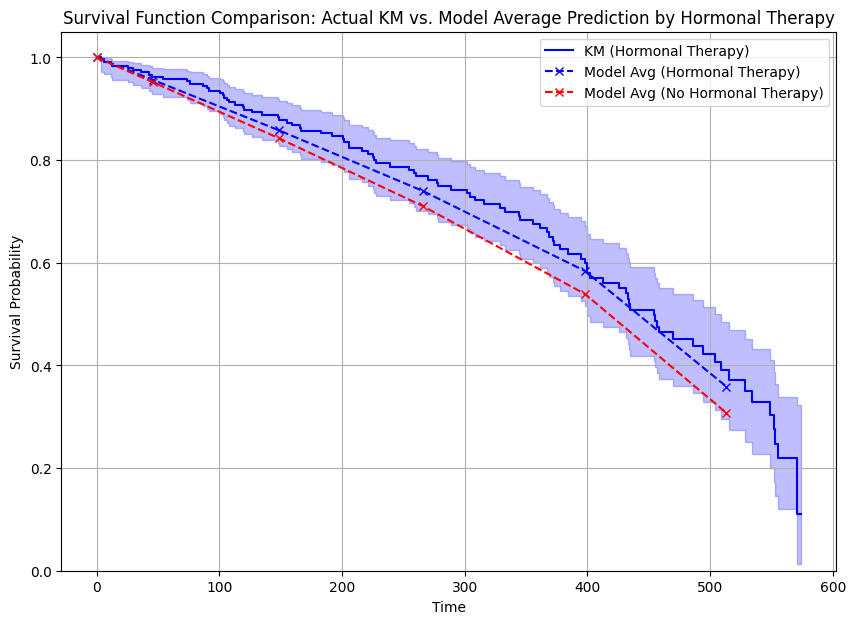


Performing Log-rank test on actual data groups:
Log-rank test p-value: 0.1358


In [7]:
# Optional: Plot Time-dependent AUC at evaluated times
if plot_auc_possible:
    auc_times, auc_scores = final_metrics["AUC_at_times"]
    # Ensure lists are numpy arrays for plotting if they aren't already
    auc_times = np.array(auc_times)
    auc_scores = np.array(auc_scores)
    plt.figure(figsize=(10, 6))
    plt.plot(auc_times, auc_scores, marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Time-dependent AUC")
    plt.title("Time-dependent AUC Over Time (Final Model)")
    plt.grid(True)
    plt.ylim(0, 1.05) # Set y-axis limits for AUC
    plt.show()
else:
    print("\nCould not plot Time-dependent AUC as no valid AUC scores were computed.")


# --- Plot Predicted Survival Curves vs Kaplan-Meier ---
if plot_survival_curve_possible and sksurv_available: # Check if sksurv KM estimator is available
    print("\nPlotting predicted survival curves vs Kaplan-Meier for sample individuals...")

    try:
        # Get predicted hazards for the full dataset from the best model
        best_model.eval()
        all_hazards_full = []
        # Use the same DataLoader as final evaluation
        full_dataset_loader_hazards = DataLoader(dataset_full, batch_size=128, shuffle=False) # Ensure shuffle=False for consistent ordering
        with torch.no_grad():
            for X_batch, _, _ in full_dataset_loader_hazards:
                X_batch = X_batch.to(device)
                # Assuming model output is hazard or risk score; use it directly for ranking
                # If model outputs survival function directly, need a different way to rank
                preds = best_model(X_batch).cpu().numpy().flatten()
                all_hazards_full.extend(preds)
        all_hazards_full = np.array(all_hazards_full)
        # Ensure the number of hazards matches the number of samples
        if len(all_hazards_full) != len(dataset_full):
             raise ValueError(f"Mismatch between number of hazards ({len(all_hazards_full)}) and dataset size ({len(dataset_full)})")


        # Get predicted survival probabilities and times from the final evaluation metrics
        predicted_survival_probs = final_metrics["survival_probs"]
        eval_times_for_survival_plot = final_metrics["eval_times"]
        # Ensure eval_times is a list or 1D array
        if isinstance(eval_times_for_survival_plot, np.ndarray):
             eval_times_for_survival_plot = eval_times_for_survival_plot.tolist()

        # Calculate Kaplan-Meier curve for the full dataset (using y_full_data_sksurv created earlier)
        km_times, km_survival_prob = kaplan_meier_estimator(y_full_data_sksurv["event"], y_full_data_sksurv["time"])

        # Select individuals representing different risk groups based on predicted hazards/scores
        # Sort individuals by their predicted hazard (ascending order means lower risk first)
        sorted_indices_by_hazard = np.argsort(all_hazards_full)

        # Choose individuals at specific percentiles of the sorted hazards
        # Example: 10th (low risk), 50th (medium risk), 90th (high risk) percentiles
        percentiles_to_plot = [10, 50, 90]
        selected_indices = [sorted_indices_by_hazard[min(int(len(all_hazards_full) * p / 100), len(all_hazards_full) - 1)] for p in percentiles_to_plot]
        # Use min() with len() - 1 to handle potential edge cases with small datasets

        plt.figure(figsize=(10, 7))

        # Plot Kaplan-Meier curve
        plt.step(km_times, km_survival_prob, where="post", label="Kaplan-Meier (Full Dataset)", color='black', linestyle='--')

        # Plot predicted survival curves for selected individuals
        colors = ['green', 'blue', 'red'] # Colors for low, medium, high risk
        labels = ['Predicted Survival (Low Risk)', 'Predicted Survival (Medium Risk)', 'Predicted Survival (High Risk)']

        # The predicted_survival_probs are discrete points at eval_times.
        # Plotting as markers connected by lines is appropriate.
        # Add (0, 1.0) as a starting point.
        plot_times_pred = [0] + eval_times_for_survival_plot
        for i, idx in enumerate(selected_indices):
            # Ensure the index is valid
            if idx < 0 or idx >= predicted_survival_probs.shape[0]:
                 print(f"Warning: Selected index {idx} is out of bounds for predicted probabilities (shape: {predicted_survival_probs.shape}). Skipping this individual.")
                 continue
            predicted_curve = predicted_survival_probs[idx, :]
             # Ensure predicted_curve has the correct length
            if len(predicted_curve) != len(eval_times_for_survival_plot):
                 print(f"Warning: Mismatch in length between predicted curve ({len(predicted_curve)}) and eval times ({len(eval_times_for_survival_plot)}) for index {idx}. Skipping.")
                 continue
            plot_probs = [1.0] + predicted_curve.tolist()
            plt.plot(plot_times_pred, plot_probs, marker='o', markersize=4, linestyle='-', color=colors[i], label=labels[i])


        plt.xlabel("Time")
        plt.ylabel("Survival Probability")
        plt.title("Predicted Survival Curves for Sample Individuals vs Kaplan-Meier")
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1.05) # Ensure y-axis is from 0 to 1
        plt.show()

    except Exception as e:
        import traceback
        print(f"Error plotting individual survival curves: {str(e)}")
        print(traceback.format_exc()) # Print traceback for detailed debugging
        print("Could not plot predicted survival curves for sample individuals vs Kaplan-Meier.")

elif not sksurv_available:
     print("\nSkipping plotting predicted survival curves vs Kaplan-Meier because scikit-survival is not available.")
else:
    print("\nCould not plot predicted survival curves for sample individuals vs Kaplan-Meier as survival probabilities or evaluation times are not available.")


# --- Compare Model Predicted Group Survival vs Kaplan-Meier by Hormonal Therapy (Corrected Plotting) ---
if plot_group_comparison_possible:
    print("\nComparing model predicted group survival vs Kaplan-Meier by hormonal therapy...")

    try:
        # Get predicted survival probabilities and times from the final evaluation metrics
        predicted_survival_probs_full = final_metrics["survival_probs"]
        eval_times_for_group_plot = final_metrics["eval_times"]
        # Ensure eval_times is a list or 1D array
        if isinstance(eval_times_for_group_plot, np.ndarray):
             eval_times_for_group_plot = eval_times_for_group_plot.tolist()

        # --- Calculate Kaplan-Meier curves for the two groups (actual data) using lifelines ---
        kmf_hormon = KaplanMeierFitter()
        kmf_no_hormon = KaplanMeierFitter()

        # Slice the full times and events tensors using the group indices
        # Ensure indices are valid before slicing
        times_hormon = times[hormon_1_indices].numpy() if hormon_1_indices else np.array([])
        events_hormon = events[hormon_1_indices].numpy() if hormon_1_indices else np.array([])
        times_no_hormon = times[hormon_0_indices].numpy() if hormon_0_indices else np.array([])
        events_no_hormon = events[hormon_0_indices].numpy() if hormon_0_indices else np.array([])

        # Define consistent colors and labels
        color_hormon = 'blue'
        color_no_hormon = 'red'
        label_hormon_km = 'KM (Hormonal Therapy)'
        label_no_hormon_km = 'KM (No Hormonal Therapy)'
        label_hormon_pred = 'Model Avg (Hormonal Therapy)'
        label_no_hormon_pred = 'Model Avg (No Hormonal Therapy)'

        # Fit KM to each group's actual data only if data exists
        km_hormon_fitted = False
        if len(times_hormon) > 0:
            kmf_hormon.fit(durations=times_hormon, event_observed=events_hormon, label=label_hormon_km)
            km_hormon_fitted = True
        else:
            print("Warning: No data for Hormonal Therapy group KM curve.")

        km_no_hormon_fitted = False
        #if len(times_no_hormon) > 0:
            #kmf_no_hormon.fit(durations=times_no_hormon, event_observed=events_no_hormon, label=label_no_hormon_km)
            #km_no_hormon_fitted = True
        #else:
        #    print("Warning: No data for No Hormonal Therapy group KM curve.")

        # --- Calculate Model Predicted survival curves for the two groups (average) ---
        n_eval_times = len(eval_times_for_group_plot)
        # Slice the predicted survival probabilities using the group indices
        predicted_probs_hormon = predicted_survival_probs_full[hormon_1_indices, :] if hormon_1_indices else np.empty((0, n_eval_times))
        predicted_probs_no_hormon = predicted_survival_probs_full[hormon_0_indices, :] if hormon_0_indices else np.empty((0, n_eval_times))

        # Calculate the average predicted survival probability over time for each group
        # Handle cases where a group might be empty to avoid errors
        avg_predicted_hormon = np.mean(predicted_probs_hormon, axis=0) if predicted_probs_hormon.shape[0] > 0 else np.full(n_eval_times, np.nan)
        avg_predicted_no_hormon = np.mean(predicted_probs_no_hormon, axis=0) if predicted_probs_no_hormon.shape[0] > 0 else np.full(n_eval_times, np.nan)

        # --- Plotting ---
        plt.figure(figsize=(10, 7))
        ax = plt.gca() # Get current axes

        # Plot Kaplan-Meier curves using lifelines' plot method if they were fitted
        if km_hormon_fitted:
             kmf_hormon.plot_survival_function(ax=ax, color=color_hormon, linestyle='-') # label is set during fit
        if km_no_hormon_fitted:
             kmf_no_hormon.plot_survival_function(ax=ax, color=color_no_hormon, linestyle='-') # label is set during fit

        # Plot average predicted survival curves (as lines/markers at eval_times)
        # Add (0, 1.0) as a starting point for the predicted curves
        plot_times_pred = [0] + eval_times_for_group_plot

        # Plot predicted curves, checking if they are valid (not all NaN)
        plot_pred_hormon = False
        if not np.all(np.isnan(avg_predicted_hormon)):
            # Plot on the same axes
            ax.plot(plot_times_pred, [1.0] + avg_predicted_hormon.tolist(), marker='x', linestyle='--', color=color_hormon, label=label_hormon_pred)
            plot_pred_hormon = True
        else:
            print("Warning: Cannot plot average predicted survival for Hormonal Therapy group (empty or all NaN).")

        plot_pred_no_hormon = False
        if not np.all(np.isnan(avg_predicted_no_hormon)):
            # Plot on the same axes
            ax.plot(plot_times_pred, [1.0] + avg_predicted_no_hormon.tolist(), marker='x', linestyle='--', color=color_no_hormon, label=label_no_hormon_pred)
            plot_pred_no_hormon = True
        else:
            print("Warning: Cannot plot average predicted survival for No Hormonal Therapy group (empty or all NaN).")

        # Only add legend if something was plotted
        if km_hormon_fitted or km_no_hormon_fitted or plot_pred_hormon or plot_pred_no_hormon:
             ax.legend() # Let matplotlib handle the legend automatically

        plt.xlabel("Time")
        plt.ylabel("Survival Probability")
        plt.title("Survival Function Comparison: Actual KM vs. Model Average Prediction by Hormonal Therapy")
        plt.grid(True)
        plt.ylim(0, 1.05) # Ensure y-axis is from 0 to 1
        plt.show()

        # --- Perform Log-rank test using lifelines ---
        print("\nPerforming Log-rank test on actual data groups:")
        # Check if there is enough data in each group for the log-rank test
        if len(times_hormon) > 0 and len(times_no_hormon) > 0:
            try:
                results = logrank_test(
                    durations_A=times_hormon, durations_B=times_no_hormon,
                    event_observed_A=events_hormon, event_observed_B=events_no_hormon
                )
                # Print the p-value and summary
                print(f"Log-rank test p-value: {results.p_value:.4f}")
                # print(results.print_summary()) # Uncomment for full summary
            except Exception as logrank_e:
                 print(f"Error during log-rank test: {logrank_e}")
                 print("Could not perform log-rank test.")
        else:
            print("Warning: One or both groups have insufficient data. Cannot perform Log-rank test.")

    except Exception as e:
        import traceback
        print(f"Error comparing group survival curves or performing log-rank test: {str(e)}")
        print(traceback.format_exc()) # Print traceback for detailed debugging
        print("Could not plot group survival curve comparison or perform log-rank test.")

elif not lifelines_available:
     print("\nSkipping group survival comparison because lifelines library is not available.")
elif not plot_survival_curve_possible:
     print("\nSkipping group survival comparison because survival probabilities are not available.")
elif len(hormon_1_indices) == 0 or len(hormon_0_indices) == 0:
     print("\nSkipping group survival comparison because one or both hormonal therapy groups are empty.")
else:
    print("\nCould not plot group survival comparison or perform log-rank test for other reasons.")

Error computing Time-dependent AUC: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

No Hormonal Therapy Metrics:
  Ctd: 0.7752
  AUC: 0.8137
  IBS: 0.1451
  Avg ECE: 0.1705
  Avg Brier: 0.1354

Hormonal Therapy Metrics:
  Ctd: 0.7955
  AUC: 0.8542
  IBS: 0.1148
  Avg ECE: 0.2002
  Avg Brier: 0.1045


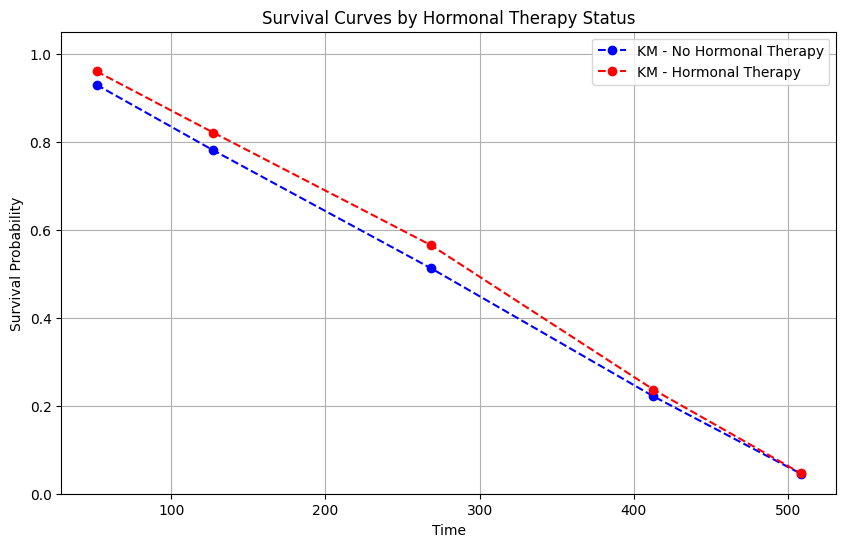


Log-rank test p-value: 0.1358


In [8]:
# --- Group Evaluation at 75th Percentile ---
def evaluate_hormonal_groups(best_model, dataset_full, hormon_indices_list, device, eval_times, y_train):
    """
    Evaluate model performance on hormonal therapy groups (75th percentile split)

    Args:
        best_model: Trained PyTorch model
        dataset_full: Full dataset tensor
        hormon_indices_list: List of indices for hormonal groups
        device: Device to use
        eval_times: Evaluation time points
        y_train: Training survival data for sksurv metrics

    Returns:
        Dictionary containing metrics for each group
    """
    group_metrics = {}
    group_names = ['No Hormonal Therapy', 'Hormonal Therapy']

    for idx, indices in enumerate(hormon_indices_list):
        if len(indices) == 0:
            print(f"Warning: No samples in group {group_names[idx]}. Skipping evaluation.")
            continue

        group_loader = DataLoader(Subset(dataset_full, indices), batch_size=128)

        # Ensure y_train is Surv object and eval_times are valid
        group_results = evaluate_model(
            best_model,
            group_loader,
            device,
            [t for t in eval_times if t < y_train['time'].max()],
            y_train
        )

        group_metrics[group_names[idx]] = group_results
        print(f"\n{group_names[idx]} Metrics:")
        print(f"  Ctd: {group_results['Ctd']:.4f}")
        print(f"  AUC: {group_results['AUC']:.4f}")
        print(f"  IBS: {group_results['IBS']:.4f}")
        print(f"  Avg ECE: {np.nanmean(group_results['ECE_at_times']):.4f}")
        print(f"  Avg Brier: {np.nanmean(group_results['Brier_at_times']):.4f}")

    return group_metrics

# --- Survival Curve Comparison ---
def plot_group_survival_curves(best_model, dataset_full, hormon_indices_list, times, events, eval_times, device):
    best_model.eval()
    group_survival = []

    with torch.no_grad():
        for indices in hormon_indices_list:
            if len(indices) == 0:
                group_survival.append(None)
                continue

            X_group = torch.stack([dataset_full[i][0] for i in indices]).to(device)
            hazards = best_model(X_group).cpu().numpy().flatten()

            order = np.argsort(times[indices])
            sorted_hazards = hazards[order]
            sorted_times = times[indices][order]
            sorted_events = events[indices][order]

            unique_times = np.unique(sorted_times[sorted_events])
            baseline_hazard = {}
            for t in unique_times:
                risk_set = np.where(sorted_times >= t)[0]
                risk_sum = np.sum(np.exp(sorted_hazards[risk_set])) if len(risk_set) > 0 else 0
                events_at_t = np.sum(sorted_times == t)
                baseline_hazard[t] = events_at_t / risk_sum if risk_sum > 0 else 0

            survival_probs = np.zeros(len(eval_times))
            cum_hazard = 0
            for i, t in enumerate(eval_times):
                relevant_times = [ut for ut in unique_times if ut <= t]
                if relevant_times:
                    cum_hazard += sum(baseline_hazard[ut] for ut in relevant_times)
                survival_probs[i] = np.exp(-cum_hazard * np.mean(np.exp(sorted_hazards)))

            group_survival.append(survival_probs)

    plt.figure(figsize=(10, 6))
    colors = ['blue', 'red']
    labels = ['No Hormonal Therapy', 'Hormonal Therapy']

    # Store legend handles and labels manually
    legend_handles = []

    for i, survival_probs in enumerate(group_survival):
        if survival_probs is None:
            continue

        # Kaplan-Meier Plot
        kmf = KaplanMeierFitter()
        kmf.fit(times[hormon_indices_list[i]], event_observed=events[hormon_indices_list[i]])
        #km_line = kmf.plot_survival_function(color=colors[i])  # Do NOT include label here
        #legend_handles.append(km_line.get_lines()[0])  # Manually add KM line to legend

        # Model prediction plot
        model_line, = plt.plot(
            eval_times,
            survival_probs,
            linestyle='--',
            marker='o',
            color=colors[i],
            label=f'Model - {labels[i]}'
        )
        legend_handles.append(model_line)

    # Create legend manually
    plt.legend(legend_handles, [f'KM - {l}' for l in labels] + [f'Model - {l}' for l in labels])
    plt.title('Survival Curves by Hormonal Therapy Status')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.show()

# --- Main Execution with Fixes ---
if __name__ == "__main__":
    # Convert tensors to NumPy arrays for plotting functions
    times_np = times.numpy()
    events_np = events.numpy()

    # Final evaluation on full dataset
    final_eval_times = np.percentile(times_np, [10, 25, 50, 75, 90])
    full_loader = DataLoader(dataset_full, batch_size=128)
    y_full = Surv.from_arrays(event=events_np, time=times_np)

    # Final model training and evaluation
    final_metrics = evaluate_model(best_model, full_loader, device, final_eval_times, y_full)

    # Group evaluation
    hormon_indices_list = [hormon_0_indices, hormon_1_indices]
    group_metrics = evaluate_hormonal_groups(
        best_model,
        dataset_full,
        hormon_indices_list,
        device,
        final_eval_times,
        y_full
    )

    # Survival curve plotting
    plot_group_survival_curves(
        best_model,
        dataset_full,
        hormon_indices_list,
        times_np,  # Use NumPy arrays
        events_np,
        final_eval_times,
        device
    )

    # Log-rank test
    if len(hormon_0_indices) > 0 and len(hormon_1_indices) > 0:
        results = logrank_test(
            durations_A=times_np[hormon_0_indices],
            durations_B=times_np[hormon_1_indices],
            event_observed_A=events_np[hormon_0_indices],
            event_observed_B=events_np[hormon_1_indices]
        )
        print(f"\nLog-rank test p-value: {results.p_value:.4f}")